# Geneal code

In [20]:
with open("/dsi/sbm/OrrBavly/colon_data/graphs/G_overlap_lcc_254_gnn_new.pkl", 'rb') as f:
    G_new = pickle.load(f)
with open("/dsi/sbm/OrrBavly/colon_data/graphs/G_overlap_lcc_246_gnn.pkl", 'rb') as f:
    G_old = pickle.load(f)

Number of Nodes in old but not new: 13
Number of Nodes in new but not old: 21
Number of shared nodes: 233
Number of Edges in old but not new: 308
Number of Edges in new but not old: 316
Number of shared edges: 297


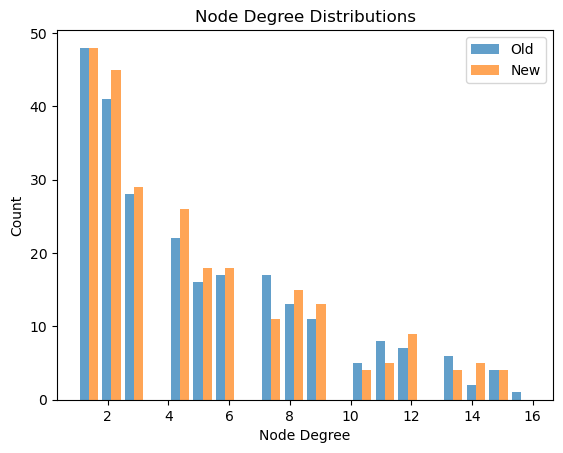

Old LCC size: 246
New LCC size: 254


In [21]:
# Node and edge sets
old_nodes = set(G_old.nodes())
new_nodes = set(G_new.nodes())

old_edges = set(G_old.edges())
new_edges = set(G_new.edges())

print("Number of Nodes in old but not new:", len(old_nodes - new_nodes))
print("Number of Nodes in new but not old:", len(new_nodes - old_nodes))
print("Number of shared nodes:", len(old_nodes & new_nodes))

print("Number of Edges in old but not new:", len(old_edges - new_edges))
print("Number of Edges in new but not old:", len(new_edges - old_edges))
print("Number of shared edges:", len(old_edges & new_edges))

# Degree comparison
import matplotlib.pyplot as plt
old_degrees = list(dict(G_old.degree()).values())
new_degrees = list(dict(G_new.degree()).values())

plt.hist([old_degrees, new_degrees],
         bins=20, label=["Old", "New"], alpha=0.7)
plt.legend()
plt.title("Node Degree Distributions")
plt.xlabel("Node Degree")
plt.ylabel("Count")
plt.show()
# Connected components
print("Old LCC size:", len(max(nx.connected_components(G_old), key=len)))
print("New LCC size:", len(max(nx.connected_components(G_new), key=len)))

In [22]:
lost_nodes = list(old_nodes - new_nodes)
gained_nodes = list(new_nodes - old_nodes)

print("Degrees of lost nodes (in old graph):", [G_old.degree(n) for n in lost_nodes])
print("Degrees of gained nodes (in new graph):", [G_new.degree(n) for n in gained_nodes])


Degrees of lost nodes (in old graph): [3, 1, 4, 1, 8, 1, 8, 1, 8, 1, 9, 4, 4]
Degrees of gained nodes (in new graph): [1, 1, 1, 3, 4, 2, 3, 2, 2, 1, 2, 9, 2, 5, 1, 1, 1, 8, 3, 1, 2]


In [23]:
lost_edges = list(set(G_old.edges()) - set(G_new.edges()))

# Print basic stats:
print(f"Number of lost edges: {len(lost_edges)}")

# Degree of both endpoints in old graph
critical_lost_edges = []
for u, v in lost_edges:
    deg_u = G_old.degree(u)
    deg_v = G_old.degree(v)
    if deg_u > 5 and deg_v > 5:  # Change threshold as needed
        critical_lost_edges.append((u, v, deg_u, deg_v))

print("Lost edges connecting high-degree nodes (>5):")
for u, v, deg_u, deg_v in critical_lost_edges:
    print(f"{u} (deg={deg_u}) -- {v} (deg={deg_v})")


Number of lost edges: 308
Lost edges connecting high-degree nodes (>5):
CASSPGQTNQPQHF (deg=8) -- CASSLSGRSSYEQYF (deg=8)
CASSPSDTQYF (deg=6) -- CASSLGSLYGYTF (deg=8)
CASSFSGGNTEAFF (deg=7) -- CASSGTNEKLFF (deg=8)
CASSYDRDQPQHF (deg=10) -- CSVDRANTGELFF (deg=9)
CASSPTGGGQPQHF (deg=15) -- CASSGNEQFF (deg=12)
CASSLQGRETQYF (deg=11) -- CASSLGGIYEQYF (deg=13)
CASSLVPGNTEAFF (deg=9) -- CASSRTGYGYTF (deg=15)
CASSLGRGYNEQFF (deg=8) -- CASSLAGAEETQYF (deg=8)
CASSRRENTEAFF (deg=9) -- CASSLGQGFSYEQYF (deg=9)
CASSLDGGSGNTIYF (deg=8) -- CASSIGETQYF (deg=12)
CASSYDRDQPQHF (deg=10) -- CASSPLAGGPTDTQYF (deg=9)
CASSLQGRETQYF (deg=11) -- CASSPGHSTDTQYF (deg=15)
CASSLVPGNTEAFF (deg=9) -- CASSRGQGGSYEQYF (deg=12)
CASSLGGQGTDTQYF (deg=11) -- CASSTTGNTEAFF (deg=7)
CASSRRENTEAFF (deg=9) -- CASSLNFYEQYF (deg=14)
CASSRGADTQYF (deg=6) -- CASSFGQGTYEQYF (deg=15)
CASSSGTAYGYTF (deg=6) -- CASSRQSTDTQYF (deg=9)
CASSLLSSGANVLTF (deg=6) -- CASSLSSGNNEQFF (deg=9)
CASSLQGRETQYF (deg=11) -- CASSLGGGTYNEQFF (deg=7)
CASS

In [ ]:
mixcr_dir = "/dsi/sbm/OrrBavly/colon_data/new_mixcr/TRB/"
meta_file = "/home/dsi/orrbavly/GNN_project/data/colon_meta_time.csv"

time_threshold = 750
meta_df = pd.read_csv(meta_file)
meta_df = meta_df[["Sample_ID", "extraction_time"]]

colon_meta = pd.read_csv("/home/dsi/orrbavly/GNN_project/data/metadata/colon_meta.csv")
colon_meta = colon_meta.loc[:, ~colon_meta.columns.str.contains('^Unnamed')]
exclude_samples = ['P2-S8', 'P2-S9', 'P2-S19', 'P8-S18'] # 'P4-S1'
relevant_values = ['0', '1', '1a', '1b', '2']
colon_meta = colon_meta[colon_meta['N'].isin(relevant_values)]
colon_meta = colon_meta[~colon_meta['sample_id'].isin(exclude_samples)].copy()
valid_samples = colon_meta[colon_meta['N'].isin(['0', '1', '1a', '1b', '2'])]['sample_id'].tolist()


# Columns to keep from MiXCR files
mixcr_cols = [
    "aaSeqCDR3", "nSeqCDR3", "readCount", 'readFraction',
    "allVHitsWithScore", "allDHitsWithScore", "allJHitsWithScore"
]
clonotype_dfs = []

for fname in os.listdir(mixcr_dir):
    if fname.endswith(".tsv") and os.path.isfile(os.path.join(mixcr_dir, fname)):
        sample_prefix = fname.split("_")[0]
        file_path = os.path.join(mixcr_dir, fname)
        if sample_prefix in valid_samples:
            df = pd.read_csv(file_path, sep="\t", usecols=mixcr_cols)
            df["Sample_ID"] = sample_prefix
            clonotype_dfs.append(df)

clonotype_df_test = pd.concat(clonotype_dfs, ignore_index=True)

# Merge with metadata to get extraction time
clonotype_df_test = clonotype_df_test.merge(meta_df, on="Sample_ID", how="inner")
# Create 'group' column: fast vs slow
clonotype_df_test["group"] = clonotype_df_test["extraction_time"].apply(lambda x: "fast" if x <= time_threshold else "slow")

In [ ]:
removed_sample_id = 'P3-S11'  # change as appropriate
tcrs_in_removed_sample = set(clonotype_df_test[clonotype_df_test['Sample_ID'] == removed_sample_id]['aaSeqCDR3'])

# Which of these TCRs are among the lost nodes?
lost_nodes = set(G_old.nodes()) - set(G_new.nodes())
unique_to_removed = tcrs_in_removed_sample & lost_nodes

print("TCRs from the removed sample that are now missing in the new graph:")
print(unique_to_removed)
print(f"Count: {len(unique_to_removed)}")

TCRs from the removed sample that are now missing in the new graph:
set()
Count: 0


In [ ]:
# For each lost node, count the number of samples it appeared in (before removal)
lost_node_counts = {}
for node in lost_nodes:
    count = clonotype_df_test[clonotype_df_test['aaSeqCDR3'] == node]['Sample_ID'].nunique()
    lost_node_counts[node] = count

print("Lost nodes and the number of samples they appeared in:")
print(lost_node_counts)


Lost nodes and the number of samples they appeared in:
{'CASSLGRGYNEQFF': 27, 'CASSGTNEKLFF': 11, 'CASSLAPGRNTEAFF': 13, 'CASSGQSSYNEQFF': 16, 'CASSLRGPYEQYF': 47, 'CASSPEGNYGYTF': 24, 'CASSLVPGNTEAFF': 30, 'CASSPWTGGSYEQYF': 14, 'CASSYGGSYGYTF': 9, 'CASSLLQGAYEQYF': 20, 'CASSLGQVSYEQYF': 30, 'CASSWGQGTGELFF': 26}


# Load Data

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # This will force CUDA to report errors immediately when they happen, giving you the correct line number.
import numpy as np 
import pandas as pd
import pickle
import networkx as nx
import dgl
import torch


In [5]:
with open("/dsi/efroni-lab/sbm/OrrBavly/colon_data/graphs/G_overlap_lcc_246_gnn.pkl", 'rb') as f:
    G_overlap = pickle.load(f)
node_meta = pd.read_csv("/home/dsi/orrbavly/GNN_project/outputs/colon/g_overlap_lcc_246_node_meta_gnn.csv")
node_meta = node_meta.loc[:, ~node_meta.columns.str.contains('^Unnamed')]
colon_meta = pd.read_csv("/home/dsi/orrbavly/GNN_project/data/metadata/colon_meta.csv")
colon_meta = colon_meta.loc[:, ~colon_meta.columns.str.contains('^Unnamed')]
valid_samples = colon_meta[colon_meta['N'].isin(['0', '1', '1a', '1b', '2'])]['sample_id'].tolist()


In [41]:
node_meta

,id,sum_fast_weight,avg_fast_weight,sum_slow_weight,avg_slow_weight,V_gene_fast,J_gene_fast,codon_diversity_fast,sample_prevalence_fast,V_gene_slow,...,codon_diversity_slow,sample_prevalence_slow,degree,betweenness,closeness,eigenvector,V_gene_fast_id,V_gene_slow_id,J_gene_fast_id,J_gene_slow_id
0,CASSLLAGTYNEQFF,0.633450,0.633450,0.621356,0.621356,TRBV11-1,TRBJ2-1,38,46,TRBV11-1,...,11,11,1,0.000000,0.111162,1.603855e-05,3,3,6,6
1,CASSSVNQPQHF,1.370906,0.685453,1.590651,0.795326,TRBV6-2,TRBJ1-5,9,15,TRBV12-3,...,5,5,2,0.008163,0.110709,1.389661e-04,25,6,4,4
2,CASSLGDRDTGELFF,9.108662,0.759055,9.535913,0.794659,TRBV12-3,TRBJ2-2,20,29,TRBV11-2,...,6,7,12,0.003569,0.095741,7.238639e-05,6,4,7,7
3,CASSFGGNEKLFF,0.617424,0.617424,0.664843,0.664843,TRBV12-3,TRBJ1-4,20,24,TRBV12-3,...,6,6,1,0.000000,0.089842,4.963792e-07,6,6,3,3
4,CASSLAGAEAFF,6.572671,0.730297,5.968546,0.663172,TRBV11-2,TRBJ1-1,25,29,TRBV5-1,...,5,5,9,0.121807,0.124809,1.275793e-01,4,22,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,CASSYGSNQPQHF,0.673082,0.673082,0.695346,0.695346,TRBV12-3,TRBJ1-5,20,42,TRBV12-3,...,8,7,1,0.000000,0.089123,4.596769e-07,6,6,4,4
242,CASSPSDTQYF,3.974290,0.662382,5.055111,0.842518,TRBV18,TRBJ2-3,39,64,TRBV11-2,...,14,16,6,0.002750,0.106153,3.085686e-04,11,4,8,8
243,CASSPGLDYEQYF,3.207921,0.641584,3.726921,0.745384,TRBV11-2,TRBJ2-7,27,28,TRBV18,...,4,5,5,0.085812,0.108025,2.801964e-05,4,11,11,11
244,CASSLNQGNTEAFF,1.364046,0.682023,1.347463,0.673732,TRBV11-1,TRBJ1-1,10,16,TRBV11-2,...,5,5,2,0.000000,0.073200,7.119434e-09,3,4,0,0


The global correlation graph was built from all 210 repertoires, but supervised training and evaluation used only the 159?160? samples with clinical phenotype labels.  Unlabeled repertoires contributed to graph topology and node statistics but were not included in the loss function or reported metrics.

In [6]:
relevant_values = ['0', '1', '1a', '1b', '2']
# List of samples to exclude - did not undergo mixcr due to missing lanes.
exclude_samples = ['P2-S8', 'P2-S9', 'P2-S19', 'P8-S18'] # 'P4-S1'
colon_meta = colon_meta[colon_meta['N'].isin(relevant_values)]
colon_meta = colon_meta[~colon_meta['sample_id'].isin(exclude_samples)].copy()
colon_meta

,filename,sum value,T,N,M,sample_id
0,pool1_S1_TRB_mig_cdr3_clones_all,33296,T3,1b,Mx,P1-S1
2,pool1_S11_TRB_mig_cdr3_clones_all,78560,T2,0,Mx,P1-S11
3,pool1_S12_TRB_mig_cdr3_clones_all,190517,T3,0,Mx,P1-S12
4,pool1_S13_TRB_mig_cdr3_clones_all,72593,T3,0,0,P1-S13
7,pool1_S16_TRB_mig_cdr3_clones_all,270087,T4,1,0,P1-S16
...,...,...,...,...,...,...
209,pool9_S3_TRB_mig_cdr3_clones_all,190092,T1,0,0,P9-S3
210,pool9_S4_TRB_mig_cdr3_clones_all,198511,T2,1,0,P9-S4
211,pool9_S5_TRB_mig_cdr3_clones_all,62094,T3,1,0,P9-S5
213,pool9_S7_TRB_mig_cdr3_clones_all,170894,T2,0,X,P9-S7


In [7]:
ih_df = pd.read_csv("/home/dsi/orrbavly/GNN_project/outputs/colon_hardness_rf_cos_every5_new_mixcr.csv")
ih_df['sample_id'] = ih_df['sample_name'].str.extract(r'^(P\d+-S\d+)')
ih_df
print(ih_df['sample_id'].nunique())

147


In [ ]:
mixcr_dir = "/dsi/efroni-lab/sbm/OrrBavly/colon_data/new_mixcr/TRB/"
meta_file = "/home/dsi/orrbavly/GNN_project/data/colon_meta_time.csv"

time_threshold = 750
meta_df = pd.read_csv(meta_file)
meta_df = meta_df[["Sample_ID", "extraction_time"]]

# Columns to keep from MiXCR files
mixcr_cols = [
    "aaSeqCDR3", "nSeqCDR3", "readCount", 'readFraction',
    "allVHitsWithScore", "allDHitsWithScore", "allJHitsWithScore"
]
clonotype_dfs = []

for fname in os.listdir(mixcr_dir):
    if fname.endswith(".tsv") and os.path.isfile(os.path.join(mixcr_dir, fname)):
        sample_prefix = fname.split("_")[0]
        file_path = os.path.join(mixcr_dir, fname)
        if sample_prefix in valid_samples:
            df = pd.read_csv(file_path, sep="\t", usecols=mixcr_cols)
            df["Sample_ID"] = sample_prefix
            clonotype_dfs.append(df)

clonotype_df = pd.concat(clonotype_dfs, ignore_index=True)

# Merge with metadata to get extraction time
clonotype_df = clonotype_df.merge(meta_df, on="Sample_ID", how="inner")
# Create 'group' column: fast vs slow
clonotype_df["group"] = clonotype_df["extraction_time"].apply(lambda x: "fast" if x <= time_threshold else "slow")

# Remove samples with no metadata (e.g., extraction time or label)
valid_meta_ids = set(colon_meta['sample_id'].unique())
clonotype_df = clonotype_df[clonotype_df['Sample_ID'].isin(valid_meta_ids)].copy()


In [40]:
clonotype_df['Sample_ID'].nunique()

160

Connect to GPU

# GNN

## Model Functions

In [2]:
import logging
def connect_gpu():

    GPU_DEVICE = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if device.type == "cpu":
        logging.warning("CUDA is not available, using CPU for training.")
    else:
        # Print available devices
        num_devices = torch.cuda.device_count()
        logging.info(f"CUDA is available. Number of devices: {num_devices}")
        print(f"CUDA is available. Number of devices: {num_devices}")

        # Try connecting to the specific device
        try:
            torch.cuda.set_device(GPU_DEVICE)  # SET GPU INDEX HERE:
            current_device = torch.cuda.current_device()
            device_name = torch.cuda.get_device_name(current_device)
            logging.info(f"Using GPU device {current_device}: {device_name}")
            print(f"Using GPU device {current_device}: {device_name}")
        except Exception as e:
            logging.error(f"Failed to connect to GPU: {e}")
            device = torch.device("cpu")
    return device

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import dgl
import pandas as pd
from sklearn.preprocessing import StandardScaler

class SingleGraphSampleDataset(Dataset):
    """
    One item = (graph, dyn_features, presence_mask, label)
    dyn_features  : FloatTensor [num_nodes, D_dyn]
    presence_mask : BoolTensor  [num_nodes]  (True for nodes that appear in sample)
    """
    def __init__(
        self, 
        g_overlap: dgl.DGLGraph,
        node_static_df: pd.DataFrame,
        dynamic_tensor_dict: dict,   # sample_id -> FloatTensor[num_nodes, D_dyn]
        presence_mask_dict: dict,    # sample_id -> BoolTensor[num_nodes]
        label_series: pd.Series,     # index=sample_id, value=label
    ):
        self.g = g_overlap

        # # store static features inside the graph once
        # self.g.ndata["static"] = torch.tensor(
        #     node_static_df.values, dtype=torch.float32
        # )
        
        # 1. Define which columns are integer IDs for the embedding layers.
        id_cols = [
            "V_gene_fast_id", "J_gene_fast_id",
            "V_gene_slow_id", "J_gene_slow_id"
        ]
        
        # 2. Define any other string-based columns that are not features.
        string_cols = ["id", "V_gene_fast", "J_gene_fast", "V_gene_slow", "J_gene_slow"]
        
        # 3. Create the list of all columns to exclude from the main numeric tensor.
        cols_to_exclude = id_cols + string_cols
        
        # 4. Get the final list of purely numeric feature columns.
        numeric_feature_cols = [c for c in node_static_df.columns if c not in cols_to_exclude]
        # 5. Store the NUMERICAL static features as torch.float32.
        self.g.ndata["static"] = torch.tensor(
            node_static_df[numeric_feature_cols].values, dtype=torch.float32
        )

        # 6. Store the pre-computed CATEGORICAL ID features as torch.long.
        for col_name in id_cols:
            self.g.ndata[col_name] = torch.tensor(
                node_static_df[col_name].values, dtype=torch.long
            )

        # -------------------------
        self.samples = list(label_series.index)
        # Convert to string (in case some are int/float), then map '0' -> 0, else 1
        labels = [0 if str(v) == '0' else 1 for v in label_series.values]
        self.y = torch.tensor(labels, dtype=torch.long)
        self.dyn = dynamic_tensor_dict
        self.mask = presence_mask_dict

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sid = self.samples[idx]
        return (
            self.g,                      # shared pointer, no copy
            self.dyn[sid],               # [N,D_dyn]
            self.mask[sid],              # [N]
            self.y[idx]                  # scalar
        )

def collate_fn(batch):
    """Batch size = number of samples in batch (NOT graph batching)."""
    g_list, dyn_list, mask_list, label_list = zip(*batch)
    # All g_list items are the same pointer; keep one
    g = g_list[0]
    dyn = torch.stack(dyn_list, dim=0)      # [B,N,D_dyn]
    mask = torch.stack(mask_list, dim=0)    # [B,N]
    labels = torch.tensor(label_list)       # [B]
    return g, dyn, mask, labels


In [4]:
import torch.nn as nn
import dgl.nn as dglnn

# older version - before removing _id columns from node_meta, and scaling them insided maskedGIN.
# class MaskedGIN(nn.Module):
#     def __init__(
#         self,
#         static_dim: int,
#         dyn_dim: int,
#         hidden_dim: int = 128,
#         num_layers: int = 3,
#         num_classes: int = 2,
#         dropout: float = 0.3,
#         readout: str = "mean"   # "mean" (default), "att", or "s2s"
#     ):
#         super().__init__()
#         self.dropout = nn.Dropout(dropout)
#         in_dim = static_dim + dyn_dim

#         self.convs = nn.ModuleList()
#         mlp = nn.Sequential(nn.Linear(in_dim, hidden_dim),
#                             nn.ReLU(),
#                             nn.Linear(hidden_dim, hidden_dim))
#         self.convs.append(dglnn.GINConv(mlp, "sum"))

#         for _ in range(num_layers - 1):
#             mlp = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
#                                 nn.ReLU(),
#                                 nn.Linear(hidden_dim, hidden_dim))
#             self.convs.append(dglnn.GINConv(mlp, "sum"))

#         # Readout layer selection
#         if readout == "att":
#             self.pool = dglnn.GlobalAttentionPooling(nn.Linear(hidden_dim, 1)) # type: ignore
#             self.readout_dim = hidden_dim
#             self.readout_type = "att"
#         elif readout == "s2s":
#             self.pool = dglnn.Set2Set(hidden_dim, n_iters=3, n_layers=1) # type: ignore
#             self.readout_dim = 2 * hidden_dim
#             self.readout_type = "s2s"
#         else: # mean
#             self.pool = None
#             self.readout_dim = hidden_dim
#             self.readout_type = "mean"
#         self.readout = nn.Linear(self.readout_dim, num_classes) # output layer - by defualt, a perceptron; linear transformation.
#         # self.readout = nn.Sequential(nn.Linear(self.readout_dim, 64), nn.ReLU(), nn.Linear(64, num_classes))

#     def forward(self, g, dyn_feat, presence_mask):
#         static = g.ndata["static"]                    # [N, static_dim]
#         B, N, D_dyn = dyn_feat.shape                  # Batch size, num_nodes, dyn_dim
#         static_expand = static.unsqueeze(0).expand(B, -1, -1)
#         h = torch.cat([static_expand, dyn_feat], dim=-1)
#         mask_expand = presence_mask.unsqueeze(-1).float()
#         h = h * mask_expand
#         h = h.view(-1, h.shape[-1])

#         batched_g = dgl.batch([g] * B).to(h.device)
#         batched_g.ndata["h"] = h

#         x = batched_g.ndata["h"]

#         for conv in self.convs:
#             x = conv(batched_g, x)
#             x = torch.relu(x)
#             x = self.dropout(x)
#         batched_g.ndata["x"] = x

#         # Unbatch to get per-graph node features
#         x = x.view(B, N, -1)
#         mask = presence_mask.unsqueeze(-1)        # [B, N, 1]
#         x_masked = x * mask.float()

#         if self.readout_type == "att" or self.readout_type == "s2s":
#             graph_emb = self.pool(batched_g, batched_g.ndata["x"])
#         else: # mean pooling (masked)
#             denom = mask.sum(dim=1).clamp(min=1)  # Avoid div by zero
#             graph_emb = x_masked.sum(dim=1) / denom

#         return self.readout(graph_emb)

import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
import dgl.nn as dglnn

# New model - uses embedding to encode genes data, instead of simple categorial data.
class MaskedGIN(nn.Module):
    def __init__(
        self,
        static_dim: int,                # numeric part only (IDs removed)
        dyn_dim: int,
        hidden_dim: int = 128,
        num_layers: int = 3,
        num_classes: int = 2,
        dropout: float = 0.3,
        readout: str = "mean",              # "mean", "att", or "s2s"
        v_vocab=29, j_vocab=12, v_slow_vocab=30, j_slow_vocab=12    # based on max values +1 in node_meta _id columns.
    ):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        # ── 1.  Gene-ID embeddings (4 × 16 d) ──────────────────────────
        emb_dim = 16
        self.v_fast_emb = nn.Embedding(v_vocab, 16)
        self.j_fast_emb = nn.Embedding(j_vocab, 16)
        self.v_slow_emb = nn.Embedding(v_slow_vocab, 16)
        self.j_slow_emb = nn.Embedding(j_slow_vocab, 16)

        in_dim = static_dim + 4 * emb_dim + dyn_dim

        # ── 2.  GIN layers ─────────────────────────────────────────────
        self.convs = nn.ModuleList()
        mlp0 = nn.Sequential(nn.Linear(in_dim, hidden_dim), 
                             nn.BatchNorm1d(hidden_dim), 
                             nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
        self.convs.append(dglnn.GINConv(mlp0, "sum"))

        for _ in range(num_layers - 1):
            mlp = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                nn.BatchNorm1d(hidden_dim),
                                nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
            self.convs.append(dglnn.GINConv(mlp, "sum"))

        # ── 3.  Read-out choice ───────────────────────────────────────
        if readout == "att":
            self.pool = dglnn.GlobalAttentionPooling(nn.Linear(hidden_dim, 1))
            self.readout_dim = hidden_dim
        elif readout == "s2s":
            self.pool = dglnn.Set2Set(hidden_dim, n_iters=3, n_layers=1)
            self.readout_dim = 2 * hidden_dim
        else:                       # masked mean
            self.pool = None
            self.readout_dim = hidden_dim

        # ── 4.  2-layer MLP head ──────────────────────────────────────
        self.head = nn.Sequential(
            nn.Linear(self.readout_dim, 2 * self.readout_dim),
            nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(2 * self.readout_dim, num_classes)
        )

    # ------------------------------------------------------------------
    # def forward(self, g, dyn_feat, presence_mask):
    #     # numeric static part
    #     static_num = g.ndata["static"]                    # [N, static_num_dim]

    #     # gene-ID look-ups
    #     v_fast = self.v_fast_emb(g.ndata["V_gene_fast_id"])
    #     j_fast = self.j_fast_emb(g.ndata["J_gene_fast_id"])
    #     v_slow = self.v_slow_emb(g.ndata["V_gene_slow_id"])
    #     j_slow = self.j_slow_emb(g.ndata["J_gene_slow_id"])

    #     static_cat = torch.cat([static_num, v_fast, j_fast, v_slow, j_slow], -1)

    #     B, N, _ = dyn_feat.shape
    #     static_expand = static_cat.unsqueeze(0).expand(B, -1, -1)     # [B,N,F]
    #     h = torch.cat([static_expand, dyn_feat], -1)                  # [B,N,F+]
    #     h = h * presence_mask.unsqueeze(-1).float()                   # early mask
    #     h = h.view(-1, h.shape[-1])                                   # [B·N,F]

    #     # g = g.int() # added for standerized 32-bit integer indcies, for hyper tune in new
    #     bg = dgl.batch([g] * B).to(h.device)
    #     x = h
    #     for conv in self.convs:
    #         x = self.dropout(F.relu(conv(bg, x)))

    #     # reshape back, re-mask
    #     x = x.view(B, N, -1) * presence_mask.unsqueeze(-1).float()

    #     if self.pool is None:            # masked mean
    #         denom = presence_mask.sum(1).clamp(min=1).unsqueeze(-1)
    #         graph_emb = x.sum(1) / denom
    #     else:
    #         bg.ndata["x"] = x.view(-1, x.shape[-1])
    #         graph_emb = self.pool(bg, bg.ndata["x"])

    #     return self.head(graph_emb)
    
    def forward(self, g, dyn_feat, presence_mask):
        # --- 1. Feature Preparation (Your existing code is correct) ---
        # This section correctly creates your batched feature tensor 'h'.
        static_num = g.ndata["static"]
        v_fast = self.v_fast_emb(g.ndata["V_gene_fast_id"])
        j_fast = self.j_fast_emb(g.ndata["J_gene_fast_id"])
        v_slow = self.v_slow_emb(g.ndata["V_gene_slow_id"])
        j_slow = self.j_slow_emb(g.ndata["J_gene_slow_id"])
        static_cat = torch.cat([static_num, v_fast, j_fast, v_slow, j_slow], -1)

        B, N, _ = dyn_feat.shape
        static_expand = static_cat.unsqueeze(0).expand(B, -1, -1)
        h = torch.cat([static_expand, dyn_feat], -1)
        h = h * presence_mask.unsqueeze(-1).float()
        
        # Flatten features into shape [B*N, F_total]
        x = h.view(-1, h.shape[-1])

        # --- 2. GIN Message Passing (The Definitive Fix) ---

        # To avoid the underlying CUDA bug, we create a batched graph from a
        # "clean" version of 'g' that has no node data attached yet. This is more stable.
        clean_g = dgl.graph(g.edges(), num_nodes=g.number_of_nodes()).to(x.device)
        
        # Now create the batched graph. It will have B*N nodes.
        bg = dgl.batch([clean_g] * B)
        
        # Assign our batched features 'x' to the new, correctly-sized batched graph.
        # The number of nodes in `bg` now matches the number of rows in `x`.
        bg.ndata['h'] = x

        # The convolution layer now receives a consistent graph and its own features.
        h_conv = bg.ndata['h']
        for conv in self.convs:
            h_conv = self.dropout(F.relu(conv(bg, h_conv)))

        # --- 3. Readout and Pooling ---
        
        x_final = h_conv.view(B, N, -1) * presence_mask.unsqueeze(-1).float()

        if self.pool is None:  # Masked mean pooling
            denom = presence_mask.sum(1).clamp(min=1).unsqueeze(-1)
            graph_emb = x_final.sum(1) / denom
        else:
            # The pooling layers can now use the final convolved features.
            bg.ndata["x"] = h_conv
            graph_emb = self.pool(bg, bg.ndata["x"])

        return self.head(graph_emb)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
import dgl.nn as dglnn
import copy

class MaskedGAT(nn.Module):
    def __init__(
        self,
        # Node feature dimensions
        static_dim: int,
        dyn_dim: int,
        
        # Vocab sizes for embeddings
        v_vocab: int, 
        j_vocab: int,
        v_slow_vocab: int, 
        j_slow_vocab: int,
        
        # Model architecture hyperparameters
        hidden_dim: int = 128,
        num_layers: int = 3,
        num_classes: int = 2,
        dropout: float = 0.3,
        readout: str = "mean",
        
        # GAT-specific hyperparameters
        edge_feat_dim: int = 2,  # (fast_weight, slow_weight)
        num_heads: int = 4       # Number of attention heads
    ):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.num_heads = num_heads
        emb_dim = 16  # The fixed embedding size from your GIN model

        # --- 1. Gene-ID Embeddings (Same as your GIN model) ---
        self.v_fast_emb = nn.Embedding(v_vocab, emb_dim)
        self.j_fast_emb = nn.Embedding(j_vocab, emb_dim)
        self.v_slow_emb = nn.Embedding(v_slow_vocab, emb_dim)
        self.j_slow_emb = nn.Embedding(j_slow_vocab, emb_dim)

        # Calculate the total input dimension for each node
        in_dim = static_dim + (4 * emb_dim) + dyn_dim

        # --- 2. EdgeGATConv Convolution Layers (The Correction) ---
        self.convs = nn.ModuleList()

        # Input layer
        # Using the correct layer and argument names from the documentation
        self.convs.append(dglnn.EdgeGATConv(
            in_feats=in_dim,
            edge_feats=edge_feat_dim, # <-- Correct argument name
            out_feats=hidden_dim,
            num_heads=num_heads,
            feat_drop=dropout,
            attn_drop=dropout,
            allow_zero_in_degree=True
            # Note: 'residual' is not a param for this layer
        ))

        # Hidden layers
        for _ in range(num_layers - 1):
            self.convs.append(dglnn.EdgeGATConv(
                in_feats=hidden_dim * num_heads, # Input from all heads
                edge_feats=edge_feat_dim,
                out_feats=hidden_dim,
                num_heads=num_heads,
                feat_drop=dropout,
                attn_drop=dropout,
                allow_zero_in_degree=True
            ))

        # --- 3. Read-out choice ---
        self.readout_dim = hidden_dim * num_heads
        if readout == "att":
            self.pool = dglnn.GlobalAttentionPooling(nn.Linear(self.readout_dim, 1))
        elif readout == "s2s":
            self.pool = dglnn.Set2Set(self.readout_dim, n_iters=3, n_layers=1)
            self.readout_dim = self.readout_dim * 2
        else:  # masked mean
            self.pool = None

        # --- 4. 2-layer MLP head ---
        self.head = nn.Sequential(
            nn.Linear(self.readout_dim, 2 * self.readout_dim),
            nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(2 * self.readout_dim, num_classes)
        )

    def forward(self, g, dyn_feat, presence_mask):
            # --- 1. Node Feature Preparation (Same as before) ---
            static_num = g.ndata["static"]
            v_fast = self.v_fast_emb(g.ndata["V_gene_fast_id"])
            j_fast = self.j_fast_emb(g.ndata["J_gene_fast_id"])
            v_slow = self.v_slow_emb(g.ndata["V_gene_slow_id"])
            j_slow = self.j_slow_emb(g.ndata["J_gene_slow_id"])
            static_cat = torch.cat([static_num, v_fast, j_fast, v_slow, j_slow], -1)

            B, N, _ = dyn_feat.shape
            static_expand = static_cat.unsqueeze(0).expand(B, -1, -1)
            h = torch.cat([static_expand, dyn_feat], -1)
            h = h * presence_mask.unsqueeze(-1).float()
            x = h.view(-1, h.shape[-1])

            # --- 2. Graph & Edge Feature Preparation (Same as before) ---
            clean_g = dgl.graph(g.edges(), num_nodes=g.number_of_nodes()).to(x.device)
            bg = dgl.batch([clean_g] * B)
            bg.ndata['h'] = x
            edge_features = g.edata['feat'].to(x.device)
            bg.edata['feat'] = edge_features.repeat(B, 1)

            # --- 3. GATv2 Message Passing (THE FIX) ---
            h_conv = bg.ndata['h']
            e_feat = bg.edata['feat']
            
            for conv in self.convs:
                # GATv2Conv returns ONE tensor: the new node features.
                # We no longer expect a 2-tuple.
                h_conv = conv(bg, h_conv, e_feat) # <-- THE FIX IS HERE
                
                # The rest of the loop is the same
                h_conv = h_conv.flatten(1) # Flatten heads
                h_conv = self.dropout(F.relu(h_conv))

            # --- 4. Readout and Pooling (Same as before) ---
            x_final = h_conv.view(B, N, -1) * presence_mask.unsqueeze(-1).float()
            if self.pool is None:
                denom = presence_mask.sum(1).clamp(min=1).unsqueeze(-1)
                graph_emb = x_final.sum(1) / denom
            else:
                bg.ndata["x"] = h_conv
                graph_emb = self.pool(bg, bg.ndata["x"])

            return self.head(graph_emb)

In [6]:
from sklearn.preprocessing import StandardScaler

def scale_dyn_dict(train_sample_ids, all_sample_ids, orig_dyn_feat_dict):
    """Fit scaler on train samples, apply to all (returns new dict)."""
    # Stack all train features: shape [N_train_samples * num_nodes, D_dyn]
    train_dyn = torch.cat([orig_dyn_feat_dict[s] for s in train_sample_ids], dim=0).numpy()
    scaler = StandardScaler().fit(train_dyn)

    new_dyn = {}
    for s in all_sample_ids:
        arr = orig_dyn_feat_dict[s].numpy()
        arr_scaled = scaler.transform(arr)
        new_dyn[s] = torch.from_numpy(arr_scaled).float()
    return new_dyn


def build_orig_dyn_feat_dict(clonotype_df, node_idx, sample_ids, if_presence=False):
    """
    Builds the [log(readFraction)] or [log_rf, presence] dynamic feature tensor for each sample.
    Also creates a presence mask dict: torch.bool [num_nodes].
    Log-transform ReadFraction values for normalization (as original values are right-skewed, most TCRs are rare)
    and makes features more comparable. Also, changes in clonotype abundance often reflect fold-changes.
    Returns: orig_dyn_feat_dict, presence_mask_dict
    """
    orig_dyn_feat_dict = {}
    presence_mask_dict = {}
    num_nodes = len(node_idx)
    for sid in sample_ids:
        df_sample = clonotype_df[clonotype_df['Sample_ID'] == sid]
        agg = df_sample.groupby('aaSeqCDR3').agg({'readFraction': 'sum'}).reset_index()
        tcr_to_rf = dict(zip(agg['aaSeqCDR3'], agg['readFraction']))

        log_rf   = np.zeros(num_nodes, dtype=np.float32)
        presence = np.zeros(num_nodes, dtype=np.float32)
        for tcr, idx in node_idx.items():
            rf = tcr_to_rf.get(tcr, 0.0)
            log_rf[idx] = np.log1p(rf)
            presence[idx] = 1.0 if rf > 0 else 0.0

        if if_presence:
            # Stack into [num_nodes, 2]: [log_rf, presence]
            dyn = np.stack([log_rf, presence], axis=1)
        else:
            # Only [log_rf], shape [num_nodes, 1]
            dyn = log_rf[:, None]

        orig_dyn_feat_dict[sid] = torch.from_numpy(dyn).float()
        # Presence mask: torch.bool, True where presence > 0
        presence_mask_dict[sid] = torch.from_numpy(presence > 0).bool()

    return orig_dyn_feat_dict, presence_mask_dict


In [7]:
from sklearn.metrics import balanced_accuracy_score, f1_score
import torch.optim as optim

def train_one_epoch(model, loader, device, criterion, optimizer):
    model.train()
    total_loss = 0
    for g, dyn, mask, y in loader:
        dyn, mask, y = dyn.to(device), mask.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(g.to(device), dyn, mask) # calls forward function
        loss = criterion(logits, y)
        loss.backward()
        # # Gradient clipping!
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        total_loss += loss.item() * y.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    all_pred, all_true = [], []
    for g,dyn,mask,y in loader:
        probs = model(g.to(device), dyn.to(device), mask.to(device))
        preds = probs.argmax(dim=1).cpu()
        all_pred.extend(preds)
        all_true.extend(y)
    bal_acc = balanced_accuracy_score(all_true, all_pred)
    f1 = f1_score(all_true, all_pred, average="binary")
    return bal_acc, f1

from torch.utils.data import Subset

def sample_id_subset(dataset, subset_ids):
    # Get indices of these IDs in dataset.samples
    id_to_idx = {sid: i for i, sid in enumerate(dataset.samples)}
    subset_indices = [id_to_idx[sid] for sid in subset_ids]
    return Subset(dataset, subset_indices)

## General Functions

In [8]:
import networkx as nx

def intersection_graph_with_weights(G1, G2, attr1='weight', attr2='weight', new_attr1='fast_weight', new_attr2='slow_weight'):
    """
    Returns a new graph with only edges present in both G1 and G2.
    Edge attributes from G1 and G2 are preserved as new_attr1 and new_attr2.
    Only nodes with at least one shared edge will be included.
    """
    G_inter = nx.Graph()
    # Create sets of edges as (nodeA, nodeB) sorted tuples for undirected comparison
    edges1 = set(tuple(sorted(e)) for e in G1.edges())
    edges2 = set(tuple(sorted(e)) for e in G2.edges())
    shared_edges = edges1 & edges2
    
    for u, v in shared_edges:
        # Copy correlation weights from both graphs
        w1 = G1[u][v][attr1]
        w2 = G2[u][v][attr2]
        G_inter.add_edge(u, v, **{new_attr1: w1, new_attr2: w2})
    return G_inter

import numpy as np
import networkx as nx

def largest_component_size(G):
    if G.number_of_nodes() == 0:
        return 0
    return max(len(c) for c in nx.connected_components(G))

def tune_overlap_graph(
    fast_corr, slow_corr, 
    target_size=80, 
    init_min_r_fast=None, 
    init_min_r_slow=None,
    step=0.01, 
    max_iter=30, 
    tol=5, 
    verbose=True
):
    # Estimate good starting thresholds if not given
    if init_min_r_fast is None:
        fast_vals = fast_corr.values[np.triu_indices_from(fast_corr, k=1)]
        init_min_r_fast = np.percentile(fast_vals, 99)  # or adjust
    if init_min_r_slow is None:
        slow_vals = slow_corr.values[np.triu_indices_from(slow_corr, k=1)]
        init_min_r_slow = np.percentile(slow_vals, 99)
        
    min_r_fast = init_min_r_fast
    min_r_slow = init_min_r_slow
    best_diff = float('inf')
    best_result = None
    
    for i in range(max_iter):
        # Build graphs
        G_fast = build_pos_corr_graph_faster(fast_corr, min_r_fast)
        G_slow = build_pos_corr_graph_faster(slow_corr, min_r_slow)
        # Intersect
        G_overlap = intersection_graph_with_weights(G_fast, G_slow)
        # Largest component size
        lcc_size = largest_component_size(G_overlap)
        diff = abs(lcc_size - target_size)
        if verbose:
            print(f"Iter {i}: min_r_fast={min_r_fast:.4f}, min_r_slow={min_r_slow:.4f}, "
                  f"LCC size={lcc_size}, nodes={G_overlap.number_of_nodes()}, edges={G_overlap.number_of_edges()}")
        # Save best result so far
        if diff < best_diff:
            best_diff = diff
            best_result = (min_r_fast, min_r_slow, G_fast, G_slow, G_overlap, lcc_size)
        # Converged?
        if diff <= tol:
            break
        # Adjust thresholds:
        if lcc_size > target_size:
            # Too big: increase thresholds
            min_r_fast += step
            min_r_slow += step
        else:
            # Too small: decrease thresholds
            min_r_fast -= step
            min_r_slow -= step
    # Return best result
    return {
        "min_r_fast": best_result[0],
        "min_r_slow": best_result[1],
        "G_fast": best_result[2],
        "G_slow": best_result[3],
        "G_overlap": best_result[4],
        "lcc_size": best_result[5]
    }

def build_pos_corr_graph_faster(corr_matrix, min_r=None):
    """
    Efficiently build a NetworkX graph from a correlation matrix using a threshold.
    Precompute the edge list directly from the correlation matrix (using NumPy or pandas).
    Only adds edges where r >= min_r (positive correlation).
    """
    tcrs = np.array(corr_matrix.index)
    # Get upper triangle indices (excluding diagonal)
    mask = np.triu(np.ones(corr_matrix.shape, dtype=bool), k=1)
    # Get pairs and correlations
    i_idx, j_idx = np.where(mask)
    corrs = corr_matrix.values[mask]
    if min_r is not None:
        select = np.where(corrs >= min_r)[0]
        i_idx = i_idx[select]
        j_idx = j_idx[select]
        corrs = corrs[select]
    # Build edge list
    edge_list = [
        (tcrs[i], tcrs[j], {'weight': float(corr)})
        for i, j, corr in zip(i_idx, j_idx, corrs)
    ]
    # Create graph
    G = nx.Graph()
    G.add_edges_from(edge_list)
    return G

import pickle

# Save function
def save_graph(graph, filename):
    with open(filename, 'wb') as f:
        pickle.dump(graph, f)

# Load function
def load_graph(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)
    


In [9]:
import pandas as pd
import re

def create_node_meta_df_for_gnn(G_overlap):
    # This function creates static (predetermined) information about nodes (TCRs) that will be later used
    # as initial node embedding input in GNN algorithm.
    
    def aggregate_edge_weights(G, weight_key):
        """Return a dict mapping node -> sum of edge weights for that key."""
        return {
            node: sum(G[node][nbr].get(weight_key, 0) for nbr in G.neighbors(node))
            for node in G.nodes
        }

    sum_fast = aggregate_edge_weights(G_overlap, 'fast_weight')
    avg_fast = {k: v / G_overlap.degree[k] if G_overlap.degree[k] else 0 for k, v in sum_fast.items()}
    sum_slow = aggregate_edge_weights(G_overlap, 'slow_weight')
    avg_slow = {k: v / G_overlap.degree[k] if G_overlap.degree[k] else 0 for k, v in sum_slow.items()}

    overlap_node_meta_df = pd.DataFrame({'id': list(G_overlap.nodes())})
    overlap_node_meta_df['sum_fast_weight'] = overlap_node_meta_df['id'].map(sum_fast)
    overlap_node_meta_df['avg_fast_weight'] = overlap_node_meta_df['id'].map(avg_fast)
    overlap_node_meta_df['sum_slow_weight'] = overlap_node_meta_df['id'].map(sum_slow)
    overlap_node_meta_df['avg_slow_weight'] = overlap_node_meta_df['id'].map(avg_slow)

    # Define function to clean allele info from V/J genes
    def clean_vj(gene_str):
        return re.sub(r"\*.*", "", gene_str) if isinstance(gene_str, str) else gene_str

    # Generate per-group metadata from fast_df
    vj_map_fast = (
        fast_df.groupby("aaSeqCDR3")
        .agg({
            "allVHitsWithScore": lambda x: x.mode()[0] if not x.mode().empty else "",
            "allJHitsWithScore": lambda x: x.mode()[0] if not x.mode().empty else "",
            "nSeqCDR3": pd.Series.nunique,
            "Sample_ID": pd.Series.nunique
        })
        .rename(columns={
            "allVHitsWithScore": "V_gene_fast",
            "allJHitsWithScore": "J_gene_fast",
            "nSeqCDR3": "codon_diversity_fast",
            "Sample_ID": "sample_prevalence_fast"
        })
    )

    # Generate per-group metadata from slow_df
    vj_map_slow = (
        slow_df.groupby("aaSeqCDR3")
        .agg({
            "allVHitsWithScore": lambda x: x.mode()[0] if not x.mode().empty else "",
            "allJHitsWithScore": lambda x: x.mode()[0] if not x.mode().empty else "",
            "nSeqCDR3": pd.Series.nunique,
            "Sample_ID": pd.Series.nunique
        })
        .rename(columns={
            "allVHitsWithScore": "V_gene_slow",
            "allJHitsWithScore": "J_gene_slow",
            "nSeqCDR3": "codon_diversity_slow",
            "Sample_ID": "sample_prevalence_slow"
        })
    )

    # Clean allele info
    vj_map_fast["V_gene_fast"] = vj_map_fast["V_gene_fast"].apply(clean_vj)
    vj_map_fast["J_gene_fast"] = vj_map_fast["J_gene_fast"].apply(clean_vj)
    vj_map_slow["V_gene_slow"] = vj_map_slow["V_gene_slow"].apply(clean_vj)
    vj_map_slow["J_gene_slow"] = vj_map_slow["J_gene_slow"].apply(clean_vj)

    # Merge both metadata sets into it
    overlap_node_meta_df = (
        overlap_node_meta_df
        .merge(vj_map_fast, left_on='id', right_index=True, how='left')
        .merge(vj_map_slow, left_on='id', right_index=True, how='left')
    )

    # graph level stats
    degree_dict = dict(G_overlap.degree())
    betweenness = nx.betweenness_centrality(G_overlap)
    closeness = nx.closeness_centrality(G_overlap)
    eigenvector = nx.eigenvector_centrality(G_overlap, max_iter=500)

    # Convert metrics to Series with index as node IDs
    degree_series = pd.Series(degree_dict, name='degree')
    betweenness_series = pd.Series(betweenness, name='betweenness')
    closeness_series = pd.Series(closeness, name='closeness')
    eigenvector_series = pd.Series(eigenvector, name='eigenvector')

    # Merge all into overlap_node_meta_df
    overlap_node_meta_df = (
        overlap_node_meta_df
        .merge(degree_series, left_on='id', right_index=True, how='left')
        .merge(betweenness_series, left_on='id', right_index=True, how='left')
        .merge(closeness_series, left_on='id', right_index=True, how='left')
        .merge(eigenvector_series, left_on='id', right_index=True, how='left')
    )

    # Step 1: Combine all V genes to create a unified vocabulary
    all_v_genes = pd.concat([
        overlap_node_meta_df['V_gene_fast'],
        overlap_node_meta_df['V_gene_slow']
    ]).dropna().unique()
    # Step 2: Create mapping from V gene name to integer ID
    unique_v_genes = sorted(set(all_v_genes))
    v_gene_to_id = {v: i for i, v in enumerate(unique_v_genes)}
    # Step 3: Map V_gene columns to integer IDs
    overlap_node_meta_df['V_gene_fast_id'] = overlap_node_meta_df['V_gene_fast'].map(v_gene_to_id)
    overlap_node_meta_df['V_gene_slow_id'] = overlap_node_meta_df['V_gene_slow'].map(v_gene_to_id)
    # Step 1: Combine all J genes to create a unified vocabulary
    all_j_genes = pd.concat([
        overlap_node_meta_df['J_gene_fast'],
        overlap_node_meta_df['J_gene_slow']
    ]).dropna().unique()
    unique_j_genes = sorted(set(all_j_genes))
    j_gene_to_id = {j: i for i, j in enumerate(unique_j_genes)}
    overlap_node_meta_df['J_gene_fast_id'] = overlap_node_meta_df['J_gene_fast'].map(j_gene_to_id)
    overlap_node_meta_df['J_gene_slow_id'] = overlap_node_meta_df['J_gene_slow'].map(j_gene_to_id)

    return overlap_node_meta_df
	
import numpy as np
import pandas as pd
from Bio.SeqUtils.ProtParam import ProteinAnalysis

def add_tcr_biochem_features(df: pd.DataFrame, seq_col: str = "id") -> pd.DataFrame:
    """
    Add biochemical features for AA sequences in `seq_col` to the same DataFrame.
    Returns a copy with new columns:
      ['length','aromaticity','instability_index','isoelectric_point','gravy',
       'charge_7.0','molecular_weight','helix_frac','turn_frac','sheet_frac']
    """
    if seq_col not in df.columns:
        raise KeyError(f"Column '{seq_col}' not found in df")

    # Define which columns we’ll produce
    biochem_cols = [
        "length", "aromaticity", "instability_index", "isoelectric_point",
        "gravy", "charge_7.0", "molecular_weight", "helix_frac", "turn_frac", "sheet_frac"
    ]

    # Helper for one sequence
    def analyze_sequence(seq: str):
        try:
            if not isinstance(seq, str) or not seq:
                raise ValueError("empty")
            s = seq.upper()
            # Optionally reject non-standard residues to avoid ProtParam errors
            if any(c not in "ACDEFGHIKLMNPQRSTVWY" for c in s):
                raise ValueError("non-standard AA")
            prot = ProteinAnalysis(s)
            ss_h, ss_t, ss_s = prot.secondary_structure_fraction()  # helix, turn, sheet
            return {
                "length": len(s),
                "aromaticity": prot.aromaticity(),
                "instability_index": prot.instability_index(),
                "isoelectric_point": prot.isoelectric_point(),
                "gravy": prot.gravy(),
                "charge_7.0": prot.charge_at_pH(7.0),
                "molecular_weight": prot.molecular_weight(),
                "helix_frac": ss_h,
                "turn_frac": ss_t,
                "sheet_frac": ss_s,
            }
        except Exception:
            # Fill NaNs on any issue; keeps shapes consistent
            return {k: np.nan for k in biochem_cols}

    # Compute once per unique sequence
    uniq = df[seq_col].astype(str).unique()
    feat_map = {seq: analyze_sequence(seq) for seq in uniq}

    # Build features frame and merge back
    feats_df = pd.DataFrame.from_dict(feat_map, orient="index")
    feats_df.index.name = seq_col
    out = df.merge(feats_df, left_on=seq_col, right_index=True, how="left")

    return out

	

## Load Samples

In [10]:
overlap_node_meta_df = add_tcr_biochem_features(overlap_node_meta_df, seq_col="id")

NameError: name 'overlap_node_meta_df' is not defined

In [ ]:
from sklearn.preprocessing import StandardScaler

device = connect_gpu()

# If G_overlap is a NetworkX graph:
G_overlap_dgl = dgl.from_networkx(G_overlap)

node_list = list(G_overlap.nodes)
node_idx = {tcr: i for i, tcr in enumerate(node_list)}

# Drop string columns (keep *_id)
string_cols = [
    "id", "V_gene_fast", "J_gene_fast", "V_gene_slow", "J_gene_slow"
]
node_meta_numeric = node_meta.drop(columns=string_cols)

# Addition - to prevent _id columns from interfering scaling other columns
# node_meta_numeric already has the four *_id columns as integers
for col in ["V_gene_fast_id", "J_gene_fast_id",
            "V_gene_slow_id", "J_gene_slow_id"]:
    G_overlap_dgl.ndata[col] = torch.tensor(node_meta_numeric[col].values, dtype=torch.long)

node_meta_numeric = node_meta_numeric.drop(columns=["V_gene_fast_id","J_gene_fast_id","V_gene_slow_id","J_gene_slow_id"])

# List of columns to normalize
cols_to_normalize = [
    'sum_fast_weight', 'avg_fast_weight', 'sum_slow_weight',
    'avg_slow_weight', 'codon_diversity_fast', 'sample_prevalence_fast',
    'codon_diversity_slow', 'sample_prevalence_slow',
    'degree', 'betweenness', 'closeness', 'eigenvector'
]

scaler = StandardScaler()
node_meta_numeric[cols_to_normalize] = scaler.fit_transform(node_meta_numeric[cols_to_normalize])

# Check all remaining columns are numeric
assert all([np.issubdtype(dtype, np.number) for dtype in node_meta_numeric.dtypes])


In [25]:
from sklearn.model_selection import train_test_split

all_samples = colon_meta['sample_id'].tolist()
# colon_meta = colon_meta.set_index('sample_id')
labels = [0 if str(v) == "0" else 1 for v in colon_meta.set_index('sample_id').loc[all_samples, 'N']]
# r_state=2

trainval_ids, test_ids, trainval_labels, test_labels = train_test_split(
    all_samples, labels, test_size=0.15, stratify=labels)

train_ids, val_ids, train_labels, val_labels = train_test_split(
    trainval_ids, trainval_labels, test_size=0.1, stratify=trainval_labels)

In [26]:
orig_dyn_feat_dict, presence_mask_dict = build_orig_dyn_feat_dict(
    clonotype_df, node_idx, all_samples, if_presence=False)
# You must provide both the train IDs (to fit), and all IDs (to transform)
dyn_feat_dict_scaled = scale_dyn_dict(train_ids, all_samples, orig_dyn_feat_dict)


In [ ]:
from torch.utils.data import DataLoader

dataset = SingleGraphSampleDataset(
    G_overlap_dgl,
    node_meta_numeric,
    dyn_feat_dict_scaled,
    presence_mask_dict,
    colon_meta.set_index("sample_id")["N"]  # labels
)

train_set = sample_id_subset(dataset, train_ids)
val_set = sample_id_subset(dataset, val_ids)
test_set  = sample_id_subset(dataset, test_ids)

BATCH_SIZE = 16

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


## GIN

### Run

In [28]:
import copy

dyn_dim = next(iter(dyn_feat_dict_scaled.values())).shape[-1]

model = MaskedGIN(
    static_dim=node_meta_numeric.shape[1],
    dyn_dim=dyn_dim,          # len(dynamic feature columns we've added [if only readFraction, than 1])
    hidden_dim=256,
    num_layers=4,
    num_classes=2,
    dropout=0.4,
    readout='att'
).to(device)

# loss function
class_counts = np.bincount(labels)   # [101,  58]

weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
criterion  = nn.CrossEntropyLoss(weight=weights.to(device))
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0013170, weight_decay=0.0001561646)

best_ba = 0; best_f1 = 0
patience = 50
epochs_since_best = 0
max_epochs = 150
best_state = None

for epoch in range(max_epochs):
    train_loss = train_one_epoch(model, train_loader, device, criterion, optimizer)
    ba, f1 = evaluate(model, val_loader, device)
    if epoch % 5 == 0:
        print(f"Epoch {epoch:02d} | Loss {train_loss:.4f} | "
            f"Val bal-acc {ba:.3f} | Val F1 {f1:.3f}")
    if ba > best_ba:
        best_ba = ba; best_f1 = f1
        epochs_since_best = 0
        best_state = copy.deepcopy(model.state_dict())
    else:
        epochs_since_best += 1
    if epochs_since_best >= patience:
        break

test_balacc, test_f1 = evaluate(model, test_loader, device)
print(f"Test baln-acc:{test_balacc}, test F1:{test_f1}")

Epoch 00 | Loss 0.7232 | Val bal-acc 0.489 | Val F1 0.250
Epoch 05 | Loss 0.6936 | Val bal-acc 0.500 | Val F1 0.000
Epoch 10 | Loss 0.6917 | Val bal-acc 0.500 | Val F1 0.000
Epoch 15 | Loss 0.6942 | Val bal-acc 0.500 | Val F1 0.000
Epoch 20 | Loss 0.6936 | Val bal-acc 0.500 | Val F1 0.000
Epoch 25 | Loss 0.6938 | Val bal-acc 0.500 | Val F1 0.000
Epoch 30 | Loss 0.6936 | Val bal-acc 0.500 | Val F1 0.000
Epoch 35 | Loss 0.6935 | Val bal-acc 0.500 | Val F1 0.000
Epoch 40 | Loss 0.6951 | Val bal-acc 0.500 | Val F1 0.000
Epoch 45 | Loss 0.6937 | Val bal-acc 0.600 | Val F1 0.333
Epoch 50 | Loss 0.6930 | Val bal-acc 0.500 | Val F1 0.000
Test baln-acc:0.5, test F1:0.0


In [ ]:
dyn_var = dyn_feat_dict_scaled[train_ids[0]].std()
stat_var = node_meta_numeric.values.std()
print(dyn_var, stat_var)

tensor(3.4661) 1.0


### Hyper Parameter Tune

In [30]:
import numpy as np
import random
import torch
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset, DataLoader

# ----- HYPERPARAMETER SEARCH SPACE -----
np.random.seed(7)
random.seed(7)

HIDDEN_OPTIONS = [64, 128, 256, 384]
LAYER_OPTIONS = [3, 4, 5]
DROPOUT_RANGE = (0.1, 0.4)
LR_RANGE = (1e-3, 5e-3)   # log scale
WD_RANGE = (1e-5, 1e-3)   # log scale
READOUT_OPTIONS = ['mean', 'att', 's2s']
BATCH_SIZE = 16
N_TRIALS = 50  # Can reduce for quick testing

def sample_config():
    cfg = {
        'hidden': random.choice(HIDDEN_OPTIONS),
        'layers': random.choice(LAYER_OPTIONS),
        'dropout': round(random.uniform(*DROPOUT_RANGE), 3),
        'lr': 10**random.uniform(np.log10(LR_RANGE[0]), np.log10(LR_RANGE[1])),
        'wd': 10**random.uniform(np.log10(WD_RANGE[0]), np.log10(WD_RANGE[1])),
        'readout': random.choice(READOUT_OPTIONS)
        # Extend with other params if needed
    }
    return cfg

In [35]:
# ----- MAIN RANDOM SEARCH LOOP -----
results = []
dyn_dim = next(iter(dyn_feat_dict_scaled.values())).shape[-1]
r_state = 7
for trial in range(N_TRIALS):
    cfg = sample_config()
    print(f"\n--- Trial {trial+1}/{N_TRIALS} ---\nConfig: {cfg}")

    all_balacc, all_f1 = [], []
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=r_state)
    G_overlap_dgl_self_loops = dgl.add_self_loop(dgl.remove_self_loop(G_overlap_dgl))

    for fold, (train_idx, val_idx) in enumerate(kfold.split(all_samples, dataset.y)):
        train_sample_ids = [all_samples[i] for i in train_idx]
        val_sample_ids   = [all_samples[i] for i in val_idx]

        # Dynamic features (fit scaler only on train)
        dyn_feat_dict_scaled = scale_dyn_dict(train_sample_ids, all_samples, orig_dyn_feat_dict)

        # Build dataset for this fold
        dataset_fold = SingleGraphSampleDataset(
            G_overlap_dgl_self_loops, node_meta_numeric,
            dyn_feat_dict_scaled, presence_mask_dict,
            colon_meta.set_index("sample_id")["N"]
        )

        train_ds = Subset(dataset_fold, train_idx)
        val_ds   = Subset(dataset_fold, val_idx)
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
        val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

        # ----- MODEL -----
        model = MaskedGIN(
            static_dim=node_meta_numeric.shape[1], dyn_dim=dyn_dim,  
            hidden_dim=cfg['hidden'], num_layers=cfg['layers'],
            dropout=cfg['dropout'], readout=cfg['readout']
        ).to(device)

        # ----- OPTIMIZER & LOSS -----
        opt = torch.optim.AdamW(model.parameters(), lr=cfg['lr'], weight_decay=cfg['wd'])
        criterion = torch.nn.CrossEntropyLoss()  # <--- USE YOUR LOSS HERE

        best_ba = 0; best_f1 = 0
        patience = 50
        epochs_since_best = 0
        max_epochs = 120

        for epoch in range(max_epochs):
            train_one_epoch(model, train_loader, device, criterion, opt)
            tr_ba, tr_f1 = evaluate(model, train_loader, device)
            ba, f1 = evaluate(model, val_loader, device)
            if ba > best_ba:
                best_ba = ba; best_f1 = f1
                epochs_since_best = 0
            else:
                epochs_since_best += 1
            if epochs_since_best >= patience:
                break

        all_balacc.append(best_ba)
        all_f1.append(best_f1)
        print(f"fold {fold}: val_bal_acc={best_ba:.3f}, val_F1={best_f1:.3f}")

    mean_ba = np.mean(all_balacc)
    mean_f1 = np.mean(all_f1)
    std_ba = np.std(all_balacc)
    std_f1 = np.std(all_f1)
    print(f"TRIAL {trial+1}: mean bal-acc={mean_ba:.3f}±{std_ba:.3f}, mean F1={mean_f1:.3f}±{std_f1:.3f}")

    results.append({'cfg': cfg, 'mean_balacc': mean_ba, 'std_balacc': std_ba, 'mean_f1': mean_f1, 'std_f1': std_f1})




--- Trial 1/50 ---
Config: {'hidden': 64, 'layers': 4, 'dropout': 0.305, 'lr': np.float64(0.0023494261734691587), 'wd': np.float64(9.225162557357044e-05), 'readout': 'mean'}
fold 0: val_bal_acc=0.567, val_F1=0.400
fold 1: val_bal_acc=0.667, val_F1=0.625
fold 2: val_bal_acc=0.600, val_F1=0.500
fold 3: val_bal_acc=0.606, val_F1=0.500
fold 4: val_bal_acc=0.677, val_F1=0.571
TRIAL 1: mean bal-acc=0.623±0.042, mean F1=0.519±0.076

--- Trial 2/50 ---
Config: {'hidden': 64, 'layers': 3, 'dropout': 0.157, 'lr': np.float64(0.0010702759377890722), 'wd': np.float64(1.568521755033666e-05), 'readout': 'att'}
fold 0: val_bal_acc=0.542, val_F1=0.154
fold 1: val_bal_acc=0.542, val_F1=0.483
fold 2: val_bal_acc=0.642, val_F1=0.560
fold 3: val_bal_acc=0.632, val_F1=0.500
fold 4: val_bal_acc=0.677, val_F1=0.571
TRIAL 2: mean bal-acc=0.607±0.055, mean F1=0.454±0.154

--- Trial 3/50 ---
Config: {'hidden': 64, 'layers': 3, 'dropout': 0.233, 'lr': np.float64(0.0026800235974081), 'wd': np.float64(0.0001025902

In [ ]:
# ----- BEST CONFIG SELECTION -----
results_sorted = sorted(results, key=lambda x: x['mean_balacc'], reverse=True)
best_result = results_sorted[0]
print("\nBest config by mean balanced accuracy:\n", best_result)
print("\nTop 3 configs:")
for i, res in enumerate(results_sorted[:3]):
    print(f"Rank {i+1}: {res}")


Best config by mean balanced accuracy:
 {'cfg': {'hidden': 384, 'layers': 5, 'dropout': 0.198, 'lr': np.float64(0.0015669537496565866), 'wd': np.float64(0.0003973517278168833), 'readout': 'mean'}, 'mean_balacc': np.float64(0.6772727272727272), 'std_balacc': np.float64(0.054938800237341566), 'mean_f1': np.float64(0.5810714285714285), 'std_f1': np.float64(0.08674603174603175)}

Top 3 configs:
Rank 1: {'cfg': {'hidden': 384, 'layers': 5, 'dropout': 0.198, 'lr': np.float64(0.0015669537496565866), 'wd': np.float64(0.0003973517278168833), 'readout': 'mean'}, 'mean_balacc': np.float64(0.6772727272727272), 'std_balacc': np.float64(0.054938800237341566), 'mean_f1': np.float64(0.5810714285714285), 'std_f1': np.float64(0.08674603174603175)}
Rank 2: {'cfg': {'hidden': 384, 'layers': 4, 'dropout': 0.123, 'lr': np.float64(0.00432901296128346), 'wd': np.float64(3.755245491863097e-05), 'readout': 'mean'}, 'mean_balacc': np.float64(0.6722294372294373), 'std_balacc': np.float64(0.0683516609247378), 'me

### K-Fold

In [37]:
import numpy as np
import torch
import copy
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader

seeds = [0, 2, 7, 13, 42]
# seeds = np.random.randint(0,10000, size=5).tolist()
test_balaccs = []
test_f1s = []

for seed in seeds:
    print(f"\n==== Seed {seed} ====")
    # 1. Stratified split: 85% dev, 15% test
    trainval_ids, test_ids, trainval_labels, test_labels = train_test_split(
        all_samples, labels, test_size=0.15, stratify=labels, random_state=seed
    )
    # 2. Within dev, 10% val
    train_ids, val_ids, train_labels, val_labels = train_test_split(
        trainval_ids, trainval_labels, test_size=0.10, stratify=trainval_labels, random_state=seed
    )

    train_set = sample_id_subset(dataset, train_ids)
    val_set   = sample_id_subset(dataset, val_ids)
    test_set  = sample_id_subset(dataset, test_ids)

    BATCH_SIZE = 16
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_fn)
    val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    dyn_dim = next(iter(dyn_feat_dict_scaled.values())).shape[-1]
    model = MaskedGIN(
        static_dim=node_meta_numeric.shape[1],
        dyn_dim=dyn_dim,
        hidden_dim=128,
        num_layers=5,
        num_classes=2,
        dropout=0.294,
        readout="mean"
    ).to(device)

    class_counts = np.bincount(labels)
    weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
    criterion = torch.nn.CrossEntropyLoss(weight=weights.to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002087306672736472, weight_decay=0.0007211683580957234)

    best_ba = 0
    best_f1 = 0
    patience = 30
    epochs_since_best = 0
    max_epochs = 120
    best_state = None

    for epoch in range(max_epochs):
        train_loss = train_one_epoch(model, train_loader, device, criterion, optimizer)
        ba, f1 = evaluate(model, val_loader, device)
        if epoch % 5 == 0:
            print(f"Epoch {epoch:03d} | Loss {train_loss:.4f} | "
                  f"Val bal-acc {ba:.3f} | Val F1 {f1:.3f}")
        if ba > best_ba:
            best_ba = ba
            best_f1 = f1
            epochs_since_best = 0
            best_state = copy.deepcopy(model.state_dict())
        else:
            epochs_since_best += 1
        if epochs_since_best >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # Restore best weights and evaluate on test set
    model.load_state_dict(best_state)
    test_balacc, test_f1 = evaluate(model, test_loader, device)
    print(f"SEED {seed}: Test bal-acc: {test_balacc:.3f}, Test F1: {test_f1:.3f}")
    test_balaccs.append(test_balacc)
    test_f1s.append(test_f1)

# Summary: report mean ± std across all seeds
mean_balacc = np.mean(test_balaccs)
std_balacc = np.std(test_balaccs)
mean_f1 = np.mean(test_f1s)
std_f1 = np.std(test_f1s)
print("\n===== Final 5-seed Results =====")
print(f"Test bal-acc: {mean_balacc:.3f} ± {std_balacc:.3f}")
print(f"Test F1:      {mean_f1:.3f} ± {std_f1:.3f}")



==== Seed 0 ====
Epoch 000 | Loss 0.9057 | Val bal-acc 0.500 | Val F1 0.000
Epoch 005 | Loss 0.6923 | Val bal-acc 0.500 | Val F1 0.000
Epoch 010 | Loss 0.6889 | Val bal-acc 0.589 | Val F1 0.444
Epoch 015 | Loss 0.6872 | Val bal-acc 0.500 | Val F1 0.000
Epoch 020 | Loss 0.6387 | Val bal-acc 0.444 | Val F1 0.000
Epoch 025 | Loss 0.6812 | Val bal-acc 0.433 | Val F1 0.222
Epoch 030 | Loss 0.6971 | Val bal-acc 0.500 | Val F1 0.000
Epoch 035 | Loss 0.6919 | Val bal-acc 0.500 | Val F1 0.000
Epoch 040 | Loss 0.6919 | Val bal-acc 0.400 | Val F1 0.444
Epoch 045 | Loss 0.6918 | Val bal-acc 0.444 | Val F1 0.000
Epoch 050 | Loss 0.6932 | Val bal-acc 0.444 | Val F1 0.000
Epoch 055 | Loss 0.6920 | Val bal-acc 0.444 | Val F1 0.000
Epoch 060 | Loss 0.6898 | Val bal-acc 0.400 | Val F1 0.444
Epoch 065 | Loss 0.6888 | Val bal-acc 0.567 | Val F1 0.533
Epoch 070 | Loss 0.6927 | Val bal-acc 0.400 | Val F1 0.444
Epoch 075 | Loss 0.6873 | Val bal-acc 0.400 | Val F1 0.444
Epoch 080 | Loss 0.6854 | Val bal-acc 

In [1]:
from sklearn.model_selection import StratifiedKFold

all_balacc, all_f1 = [], []
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
G_overlap_dgl_self_loops = dgl.add_self_loop(dgl.remove_self_loop(G_overlap_dgl))

# orig_dyn_feat_dict, presence_mask_dict = build_orig_dyn_feat_dict(
#     clonotype_df, node_idx, all_samples, if_presence=False)
# You must provide both the train IDs (to fit), and all IDs (to transform)

for fold, (train_idx, val_idx) in enumerate(kfold.split(all_samples, dataset.y)):
    train_sample_ids = [all_samples[i] for i in train_idx]
    val_sample_ids   = [all_samples[i] for i in val_idx]

    # 2. Scale dynamic features (fit only on train, apply to all)
    dyn_feat_dict_scaled = scale_dyn_dict(train_sample_ids, all_samples, orig_dyn_feat_dict)

    # 3. Rebuild dataset for this fold (now using scaled dynamic features!)
    dataset_fold = SingleGraphSampleDataset(
        G_overlap_dgl_self_loops, node_meta_numeric,
        dyn_feat_dict_scaled, presence_mask_dict,
        colon_meta.set_index("sample_id")["N"]
    )

    train_ds = Subset(dataset_fold, train_idx)
    val_ds   = Subset(dataset_fold, val_idx)
    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)

    # Model
    model = MaskedGIN(
        static_dim=node_meta_numeric.shape[1], dyn_dim=1,  # 1 features: logRF
        hidden_dim=256, num_layers=5, dropout=0.4, attention=False
    ).to(device)
    
    opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=5e-5)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5, factor=0.5)
    criterion = torch.nn.CrossEntropyLoss() 

    best_ba = 0; best_f1 = 0; best_ba_tr = 0; best_f1_tr = 0
    for epoch in range(150):
        train_one_epoch(model, train_loader, device, criterion, opt)
        tr_ba, tr_f1 = evaluate(model, train_loader, device)
        ba, f1 = evaluate(model, val_loader, device)
        sched.step(ba)
        if ba > best_ba: best_ba = ba; best_f1 = f1
        if tr_ba > best_ba_tr: best_ba_tr = tr_ba; best_f1_tr = tr_f1
    
    all_balacc.append(best_ba); all_f1.append(best_f1)
    print(f"train: fold {fold}: bal-acc={best_ba_tr:.3f}, F1={best_f1_tr:.3f}")
    print(f"validation: fold {fold}: bal-acc={best_ba:.3f}, F1={best_f1:.3f}")

print(f"\nCV mean bal-acc {np.mean(all_balacc):.3f} ± {np.std(all_balacc):.3f}")
print(f"CV mean F1      {np.mean(all_f1):.3f} ± {np.std(all_f1):.3f}")

NameError: name 'dgl' is not defined

In [ ]:
import json, random

# ------------------------------------------------------------------
# 1.  Global deterministic settings
# ------------------------------------------------------------------
def set_all_seeds(seed: int = 0):
    # 1) Python / NumPy / Torch / DGL RNGs
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    dgl.seed(seed); dgl.random.seed(seed)

    # 2) cuDNN settings: deterministic kernels OFF, benchmarking OFF
    torch.backends.cudnn.deterministic = False   # allow fastest kernels
    torch.backends.cudnn.benchmark     = False   # keep reproducible speed

GLOBAL_SEED = 2
set_all_seeds(GLOBAL_SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def make_loader(dataset, batch_size, shuffle, seed):
    g = torch.Generator().manual_seed(seed)
    return DataLoader(dataset,
                      batch_size=batch_size,
                      shuffle=shuffle,
                      generator=g,
                      num_workers=0,
                      collate_fn=collate_fn)

# ------------------------------------------------------------------
# 2.  Utility: fit scaler once per trial
# ------------------------------------------------------------------
from sklearn.preprocessing import StandardScaler

def fit_scaler(train_ids, dyn_dict):
    arr = np.concatenate([dyn_dict[sid] for sid in train_ids], axis=0)
    return StandardScaler().fit(arr)

def transform_dyn_dict(scaler, all_ids, dyn_dict):
    return {sid: torch.tensor(scaler.transform(dyn_dict[sid]),
                              dtype=torch.float32)
            for sid in all_ids}

In [ ]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, Subset

# ------------------------------------------------------------------
# 3.  Prepare labels & sample ordering
# ------------------------------------------------------------------
all_samples = colon_meta["sample_id"].tolist()

# ------------------------------------------------------------------
# 4.  Fixed hyper-parameters (best from previous search)
# ------------------------------------------------------------------
BEST_CFG = dict(hidden=256, layers=5, dropout=0.4,
                lr=2e-3, wd=2e-5, readout="mean")
BATCH_SIZE   = 16
MAX_EPOCHS   = 200
PATIENCE     = 50

# ------------------------------------------------------------------
# 5.  5-fold CV loop
# ------------------------------------------------------------------
fold_balacc, fold_f1 = [], []
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=GLOBAL_SEED)

for fold, (tr_idx, va_idx) in enumerate(kfold.split(all_samples, dataset.y)):
    train_ids = [all_samples[i] for i in tr_idx]
    val_ids   = [all_samples[i] for i in va_idx]

    # --- fit scaler ON TRAIN ONLY, then transform all ---
    scaler = fit_scaler(train_ids, orig_dyn_feat_dict)
    dyn_scaled = transform_dyn_dict(scaler, all_samples, orig_dyn_feat_dict)
    dyn_dim = next(iter(dyn_scaled.values())).shape[1]

    # --- clone graph (self-loops) per fold ---
    g_fold = dgl.add_self_loop(dgl.remove_self_loop(G_overlap_dgl.clone()))

    dataset_fold = SingleGraphSampleDataset(
        g_fold, node_meta_numeric,
        dyn_scaled, presence_mask_dict,
        colon_meta.set_index("sample_id")["N"]
    )
    train_ds = Subset(dataset_fold, tr_idx)
    val_ds   = Subset(dataset_fold, va_idx)

    train_loader = make_loader(train_ds, BATCH_SIZE, True,  GLOBAL_SEED+fold)
    val_loader   = make_loader(val_ds,   BATCH_SIZE, False, GLOBAL_SEED+fold)

    # --- model ---
    model = MaskedGIN(static_dim=node_meta_numeric.shape[1],
                      dyn_dim=dyn_dim,
                      hidden_dim=BEST_CFG['hidden'],
                      num_layers=BEST_CFG['layers'],
                      dropout=BEST_CFG['dropout'],
                      readout=BEST_CFG['readout']).to(DEVICE)

    opt = torch.optim.AdamW(model.parameters(),
                            lr=BEST_CFG['lr'],
                            weight_decay=BEST_CFG['wd'])
    criterion = torch.nn.CrossEntropyLoss()
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5, factor=0.5)

    best_ba = best_f1 = 0
    since_best = 0

    for epoch in range(MAX_EPOCHS):
        train_one_epoch(model, train_loader, DEVICE, criterion, opt)
        ba, f1 = evaluate(model, val_loader, DEVICE)
        sched.step(ba)

        if ba > best_ba:
            best_ba, best_f1 = ba, f1
            since_best = 0
        else:
            since_best += 1
        if since_best >= PATIENCE:
            break

    fold_balacc.append(best_ba)
    fold_f1.append(best_f1)
    print(f"fold{fold}: val BA={best_ba:.3f}, F1={best_f1:.3f}")

print("\nCV mean BA = {:.3f} ± {:.3f}".format(np.mean(fold_balacc),
                                             np.std(fold_balacc)))
print("CV mean F1 = {:.3f} ± {:.3f}".format(np.mean(fold_f1),
                                            np.std(fold_f1)))

fold0: val BA=0.500, F1=0.000
fold1: val BA=0.567, F1=0.500
fold2: val BA=0.558, F1=0.516
fold3: val BA=0.515, F1=0.364
fold4: val BA=0.654, F1=0.545

CV mean BA = 0.559 ± 0.054
CV mean F1 = 0.385 ± 0.202


### TAG

In [ ]:
# 2. fit scaler ON (train+val) of first split ONLY to verify mean≈0
scaler = fit_scaler(all_samples[:120], orig_dyn_feat_dict)
print('Scaler mean first dyn feature:', scaler.mean_[0])   # sanity

Scaler mean first dyn feature: 3.377226971803393e-06


In [ ]:
# --- choose one labelled sample in the current train fold ---
sample_id = train_ids[0]            # first sample in this fold
dyn_std   = dyn_scaled[sample_id].std().item()
stat_std  = node_meta_numeric.values.std()

print(f"[A] dyn std  = {dyn_std:.3f}")
print(f"[A] stat std = {stat_std:.3f}  (should be roughly same order)")


[A] dyn std  = 1.658
[A] stat std = 1.000  (should be roughly same order)


In [ ]:
mask_ratio = presence_mask_dict[sample_id].float().mean().item()
print(f"[B] mask true ratio = {mask_ratio:.3f}  (expected ~0.15-0.25)")


[B] mask true ratio = 0.122  (expected ~0.15-0.25)


In [ ]:
def overfit_tiny_set(model_cls, train_dataset, epochs=200, seed=0):
    tiny_idx = random.sample(range(len(train_dataset)), 8)   # stratified optional
    tiny_loader = DataLoader(Subset(train_dataset, tiny_idx),
                             batch_size=8, shuffle=True,
                             collate_fn=collate_fn)
    model = model_cls().to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss  = torch.nn.CrossEntropyLoss()

    for _ in range(epochs):
        train_one_epoch(model, tiny_loader, DEVICE, loss, opt)
    ba, _ = evaluate(model, tiny_loader, DEVICE)
    return ba

ba_tiny = overfit_tiny_set(
    lambda: MaskedGIN(static_dim=node_meta_numeric.shape[1],
                      dyn_dim=dyn_dim, hidden_dim=128, num_layers=3,
                      dropout=0.203, readout='att'),
    train_ds)
print(f"[D] tiny-set bal-acc = {ba_tiny:.3f}  (should reach ≥0.90)")


[D] tiny-set bal-acc = 1.000  (should reach ≥0.90)


# Running the Pipeline Without Test Samples

## Create samples groups

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import json

separate samples into train-val, test, and unlabled.\n
Calculate corrolation stats, and construct overlap graph using largest lcc.



exclude_samples = ['P2-S8', 'P2-S9', 'P2-S19', 'P8-S18', 'P9-S25'] 


In [11]:
r_State_test = 42

In [12]:
mixcr_dir = "/dsi/efroni-lab/sbm/OrrBavly/colon_data/new_mixcr/TRB/"
meta_file = "/home/dsi/orrbavly/GNN_project/data/colon_meta_time.csv"

time_threshold = 750
meta_df = pd.read_csv(meta_file)
meta_df = meta_df[["Sample_ID", "extraction_time"]]

# Columns to keep from MiXCR files
mixcr_cols = [
    "aaSeqCDR3", "nSeqCDR3", "readCount", 'readFraction',
    "allVHitsWithScore", "allDHitsWithScore", "allJHitsWithScore"
]
clonotype_dfs = []

for fname in os.listdir(mixcr_dir):
    if fname.endswith(".tsv") and os.path.isfile(os.path.join(mixcr_dir, fname)):
        sample_prefix = fname.split("_")[0]
        file_path = os.path.join(mixcr_dir, fname)
        
        df = pd.read_csv(file_path, sep="\t", usecols=mixcr_cols)
        df["Sample_ID"] = sample_prefix
        clonotype_dfs.append(df)

clonotype_df = pd.concat(clonotype_dfs, ignore_index=True)

# Merge with metadata to get extraction time
clonotype_df = clonotype_df.merge(meta_df, on="Sample_ID", how="inner")
# Create 'group' column: fast vs slow
clonotype_df["group"] = clonotype_df["extraction_time"].apply(lambda x: "fast" if x <= time_threshold else "slow")


In [13]:
all_samples = clonotype_df['Sample_ID'].unique().tolist()
print(clonotype_df['Sample_ID'].nunique())

212


In [14]:
colon_meta = pd.read_csv("/home/dsi/orrbavly/GNN_project/data/metadata/colon_meta.csv")
colon_meta = colon_meta.loc[:, ~colon_meta.columns.str.contains('^Unnamed')]
relevant_values = ['0', '1', '1a', '1b', '2']
# List of samples to exclude - did not undergo mixcr due to missing lanes.
exclude_samples = ['P2-S8', 'P2-S9', 'P2-S19', 'P8-S18'] # 'P4-S1'
colon_meta = colon_meta[colon_meta['N'].isin(relevant_values)]
colon_meta = colon_meta[~colon_meta['sample_id'].isin(exclude_samples)].copy()

valid_samples = colon_meta['sample_id'].tolist()

In [15]:
# --- 1. match labels to valid_samples ---
labels = []
for sid in valid_samples:
    row = colon_meta.loc[colon_meta["sample_id"] == sid, "N"]
    if row.empty:
        raise ValueError(f"Sample {sid} not found in colon_meta")
    labels.append(0 if row.iloc[0] == "0" else 1)
labels = np.array(labels)

In [16]:
# --- 2. split into train_val / test ---
trainval_ids, test_ids, y_trainval, y_test = train_test_split(
    valid_samples, labels, test_size=0.15, stratify=labels, random_state=r_State_test
)

# --- 3. identify unlabeled samples ---
unlabeled_ids = [s for s in all_samples if s not in valid_samples]

# --- 4. save splits ---
splits = {
    "trainval": trainval_ids,
    "test": test_ids,
    "unlabeled": unlabeled_ids,
}
json.dump(splits, open("/dsi/efroni-lab/sbm/OrrBavly/colon_data/GNN_data/sample_splits.json", "w"), indent=2)

print(f"Train/Val: {len(trainval_ids)} | Test: {len(test_ids)} | Unlabeled: {len(unlabeled_ids)}")

Train/Val: 136 | Test: 24 | Unlabeled: 52


## TCR Corrolation

In [17]:
graph_universe_ids = trainval_ids + unlabeled_ids
len(graph_universe_ids) # should be 136 + 52 = 188

188

Now lets focus on construction set (train-val + unlabled samples).

In [18]:
sub = clonotype_df.loc[
    clonotype_df['Sample_ID'].isin(all_samples) &
    clonotype_df['group'].isin(['fast','slow'])
].copy()

# A narrow view ONLY for the survivor/qualification logic
logic_df = sub[['Sample_ID','group','aaSeqCDR3']].dropna(subset=['aaSeqCDR3','group'])

# 1) survivors: AA present in BOTH groups
presence = (logic_df.groupby(['aaSeqCDR3','group'])['Sample_ID']
                    .size().unstack(fill_value=0))
survivors = presence.index[(presence.get('fast',0) > 0) & (presence.get('slow',0) > 0)]

survivor_df = sub[sub['aaSeqCDR3'].isin(survivors)].copy()  # keeps ALL columns

threshold = 4
# 2) qualify: AA must appear in ≥ threshold UNIQUE samples in BOTH groups
counts = (survivor_df.groupby(['aaSeqCDR3','group'])['Sample_ID']
          .nunique().unstack(fill_value=0))
qualified_tcrs = counts[(counts.get('fast',0) >= threshold) &
                        (counts.get('slow',0) >= threshold)].index

# === keep these objects with ALL columns ===
qualified_df = sub[sub['aaSeqCDR3'].isin(qualified_tcrs)].copy()

fast_df = qualified_df[qualified_df['group'] == 'fast'].copy()
slow_df = qualified_df[qualified_df['group'] == 'slow'].copy()

# Expression matrices (needs 'readFraction' present in sub)
fast_expr = fast_df.pivot_table(index='aaSeqCDR3', columns='Sample_ID',
                                values='readFraction', fill_value=0)
slow_expr = slow_df.pivot_table(index='aaSeqCDR3', columns='Sample_ID',
                                values='readFraction', fill_value=0)

In [19]:
# #Pearson correlations
# fast_corr = fast_expr.T.corr(method='pearson')
# slow_corr = slow_expr.T.corr(method='pearson')
fast_expr_numpy = fast_expr.to_numpy()
fast_corr_numpy = np.corrcoef(fast_expr_numpy)
fast_corr = pd.DataFrame(fast_corr_numpy, index=fast_expr.index, columns=fast_expr.index)

slow_expr_numpy = slow_expr.to_numpy()
slow_corr_numpy = np.corrcoef(slow_expr_numpy)
slow_corr = pd.DataFrame(slow_corr_numpy, index=slow_expr.index, columns=slow_expr.index)


## Overlap Graph

In [42]:
import networkx as nx

def intersection_graph_with_weights(G1, G2, attr1='weight', attr2='weight', new_attr1='fast_weight', new_attr2='slow_weight'):
    """
    Returns a new graph with only edges present in both G1 and G2.
    Edge attributes from G1 and G2 are preserved as new_attr1 and new_attr2.
    Only nodes with at least one shared edge will be included.
    """
    G_inter = nx.Graph()
    # Create sets of edges as (nodeA, nodeB) sorted tuples for undirected comparison
    edges1 = set(tuple(sorted(e)) for e in G1.edges())
    edges2 = set(tuple(sorted(e)) for e in G2.edges())
    shared_edges = edges1 & edges2
    
    for u, v in shared_edges:
        # Copy correlation weights from both graphs
        w1 = G1[u][v][attr1]
        w2 = G2[u][v][attr2]
        G_inter.add_edge(u, v, **{new_attr1: w1, new_attr2: w2})
    return G_inter

import numpy as np
import networkx as nx

def largest_component_size(G):
    if G.number_of_nodes() == 0:
        return 0
    return max(len(c) for c in nx.connected_components(G))

def tune_overlap_graph(
    fast_corr, slow_corr, 
    target_size=80, 
    init_min_r_fast=None, 
    init_min_r_slow=None,
    step=0.01, 
    max_iter=30, 
    tol=5, 
    verbose=True
):
    # Estimate good starting thresholds if not given
    if init_min_r_fast is None:
        fast_vals = fast_corr.values[np.triu_indices_from(fast_corr, k=1)]
        init_min_r_fast = np.percentile(fast_vals, 99)  # or adjust
    if init_min_r_slow is None:
        slow_vals = slow_corr.values[np.triu_indices_from(slow_corr, k=1)]
        init_min_r_slow = np.percentile(slow_vals, 99)
        
    min_r_fast = init_min_r_fast
    min_r_slow = init_min_r_slow
    best_diff = float('inf')
    best_result = None
    
    for i in range(max_iter):
        # Build graphs
        G_fast = build_pos_corr_graph_faster(fast_corr, min_r_fast)
        G_slow = build_pos_corr_graph_faster(slow_corr, min_r_slow)
        # Intersect
        G_overlap = intersection_graph_with_weights(G_fast, G_slow)
        # Largest component size
        lcc_size = largest_component_size(G_overlap)
        diff = abs(lcc_size - target_size)
        if verbose:
            print(f"Iter {i}: min_r_fast={min_r_fast:.4f}, min_r_slow={min_r_slow:.4f}, "
                  f"LCC size={lcc_size}, nodes={G_overlap.number_of_nodes()}, edges={G_overlap.number_of_edges()}")
        # Save best result so far
        if diff < best_diff:
            best_diff = diff
            best_result = (min_r_fast, min_r_slow, G_fast, G_slow, G_overlap, lcc_size)
        # Converged?
        if diff <= tol:
            break
        # Adjust thresholds:
        if lcc_size > target_size:
            # Too big: increase thresholds
            min_r_fast += step
            min_r_slow += step
        else:
            # Too small: decrease thresholds
            min_r_fast -= step
            min_r_slow -= step
    # Return best result
    return {
        "min_r_fast": best_result[0],
        "min_r_slow": best_result[1],
        "G_fast": best_result[2],
        "G_slow": best_result[3],
        "G_overlap": best_result[4],
        "lcc_size": best_result[5]
    }

def build_pos_corr_graph_faster(corr_matrix, min_r=None):
    """
    Efficiently build a NetworkX graph from a correlation matrix using a threshold.
    Precompute the edge list directly from the correlation matrix (using NumPy or pandas).
    Only adds edges where r >= min_r (positive correlation).
    """
    tcrs = np.array(corr_matrix.index)
    # Get upper triangle indices (excluding diagonal)
    mask = np.triu(np.ones(corr_matrix.shape, dtype=bool), k=1)
    # Get pairs and correlations
    i_idx, j_idx = np.where(mask)
    corrs = corr_matrix.values[mask]
    if min_r is not None:
        select = np.where(corrs >= min_r)[0]
        i_idx = i_idx[select]
        j_idx = j_idx[select]
        corrs = corrs[select]
    # Build edge list
    edge_list = [
        (tcrs[i], tcrs[j], {'weight': float(corr)})
        for i, j, corr in zip(i_idx, j_idx, corrs)
    ]
    # Create graph
    G = nx.Graph()
    G.add_edges_from(edge_list)
    return G

import pickle

# Save function
def save_graph(graph, filename):
    with open(filename, 'wb') as f:
        pickle.dump(graph, f)

# Load function
def load_graph(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [ ]:
# tune_results = tune_overlap_graph(
#     fast_corr, slow_corr,
#     init_min_r_fast= 0.860, 
#     init_min_r_slow= 0.880,
#     target_size=10, # LCC target size
#     step=0.02,    # Try 0.01 or smaller for fine control
#     max_iter=40,
#     tol=5,         # Acceptable range
#     verbose=True
# )
# G_overlap = tune_results["G_overlap"]

In [21]:
G_fast_sub = build_pos_corr_graph_faster(fast_corr, min_r=0.75)
G_slow_sub = build_pos_corr_graph_faster(slow_corr, min_r=0.77)

G_overlap = intersection_graph_with_weights(G_fast_sub, G_slow_sub)

# # Get all connected components sorted by size (largest to smallest)
# components = sorted(nx.connected_components(G_overlap), key=len, reverse=True)
# # Extract the largest and second-largest and Create subgraphs
# G_overlap_lcc_largest = G_overlap.subgraph(components[0]).copy()
G_overlap_lcc_largest = G_overlap.copy()

In [22]:
import pandas as pd
import re

def create_node_meta_df_for_gnn(G_overlap):
    # This function creates static (predetermined) information about nodes (TCRs) that will be later used
    # as initial node embedding input in GNN algorithm.
    
    def aggregate_edge_weights(G, weight_key):
        """Return a dict mapping node -> sum of edge weights for that key."""
        return {
            node: sum(G[node][nbr].get(weight_key, 0) for nbr in G.neighbors(node))
            for node in G.nodes
        }

    sum_fast = aggregate_edge_weights(G_overlap, 'fast_weight')
    avg_fast = {k: v / G_overlap.degree[k] if G_overlap.degree[k] else 0 for k, v in sum_fast.items()}
    sum_slow = aggregate_edge_weights(G_overlap, 'slow_weight')
    avg_slow = {k: v / G_overlap.degree[k] if G_overlap.degree[k] else 0 for k, v in sum_slow.items()}

    overlap_node_meta_df = pd.DataFrame({'id': list(G_overlap.nodes())})
    overlap_node_meta_df['sum_fast_weight'] = overlap_node_meta_df['id'].map(sum_fast)
    overlap_node_meta_df['avg_fast_weight'] = overlap_node_meta_df['id'].map(avg_fast)
    overlap_node_meta_df['sum_slow_weight'] = overlap_node_meta_df['id'].map(sum_slow)
    overlap_node_meta_df['avg_slow_weight'] = overlap_node_meta_df['id'].map(avg_slow)

    # Define function to clean allele info from V/J genes
    def clean_vj(gene_str):
        return re.sub(r"\*.*", "", gene_str) if isinstance(gene_str, str) else gene_str

    # Generate per-group metadata from fast_df
    vj_map_fast = (
        fast_df.groupby("aaSeqCDR3")
        .agg({
            "allVHitsWithScore": lambda x: x.mode()[0] if not x.mode().empty else "",
            "allJHitsWithScore": lambda x: x.mode()[0] if not x.mode().empty else "",
            "nSeqCDR3": pd.Series.nunique,
            "Sample_ID": pd.Series.nunique
        })
        .rename(columns={
            "allVHitsWithScore": "V_gene_fast",
            "allJHitsWithScore": "J_gene_fast",
            "nSeqCDR3": "codon_diversity_fast",
            "Sample_ID": "sample_prevalence_fast"
        })
    )

    # Generate per-group metadata from slow_df
    vj_map_slow = (
        slow_df.groupby("aaSeqCDR3")
        .agg({
            "allVHitsWithScore": lambda x: x.mode()[0] if not x.mode().empty else "",
            "allJHitsWithScore": lambda x: x.mode()[0] if not x.mode().empty else "",
            "nSeqCDR3": pd.Series.nunique,
            "Sample_ID": pd.Series.nunique
        })
        .rename(columns={
            "allVHitsWithScore": "V_gene_slow",
            "allJHitsWithScore": "J_gene_slow",
            "nSeqCDR3": "codon_diversity_slow",
            "Sample_ID": "sample_prevalence_slow"
        })
    )

    # Clean allele info
    vj_map_fast["V_gene_fast"] = vj_map_fast["V_gene_fast"].apply(clean_vj)
    vj_map_fast["J_gene_fast"] = vj_map_fast["J_gene_fast"].apply(clean_vj)
    vj_map_slow["V_gene_slow"] = vj_map_slow["V_gene_slow"].apply(clean_vj)
    vj_map_slow["J_gene_slow"] = vj_map_slow["J_gene_slow"].apply(clean_vj)

    # Merge both metadata sets into it
    overlap_node_meta_df = (
        overlap_node_meta_df
        .merge(vj_map_fast, left_on='id', right_index=True, how='left')
        .merge(vj_map_slow, left_on='id', right_index=True, how='left')
    )

    # graph level stats
    degree_dict = dict(G_overlap.degree())
    betweenness = nx.betweenness_centrality(G_overlap)
    closeness = nx.closeness_centrality(G_overlap)
    eigenvector = nx.eigenvector_centrality(G_overlap, max_iter=500)

    # Convert metrics to Series with index as node IDs
    degree_series = pd.Series(degree_dict, name='degree')
    betweenness_series = pd.Series(betweenness, name='betweenness')
    closeness_series = pd.Series(closeness, name='closeness')
    eigenvector_series = pd.Series(eigenvector, name='eigenvector')

    # Merge all into overlap_node_meta_df
    overlap_node_meta_df = (
        overlap_node_meta_df
        .merge(degree_series, left_on='id', right_index=True, how='left')
        .merge(betweenness_series, left_on='id', right_index=True, how='left')
        .merge(closeness_series, left_on='id', right_index=True, how='left')
        .merge(eigenvector_series, left_on='id', right_index=True, how='left')
    )

    # Step 1: Combine all V genes to create a unified vocabulary
    all_v_genes = pd.concat([
        overlap_node_meta_df['V_gene_fast'],
        overlap_node_meta_df['V_gene_slow']
    ]).dropna().unique()
    # Step 2: Create mapping from V gene name to integer ID
    unique_v_genes = sorted(set(all_v_genes))
    v_gene_to_id = {v: i for i, v in enumerate(unique_v_genes)}
    # Step 3: Map V_gene columns to integer IDs
    overlap_node_meta_df['V_gene_fast_id'] = overlap_node_meta_df['V_gene_fast'].map(v_gene_to_id)
    overlap_node_meta_df['V_gene_slow_id'] = overlap_node_meta_df['V_gene_slow'].map(v_gene_to_id)
    # Step 1: Combine all J genes to create a unified vocabulary
    all_j_genes = pd.concat([
        overlap_node_meta_df['J_gene_fast'],
        overlap_node_meta_df['J_gene_slow']
    ]).dropna().unique()
    unique_j_genes = sorted(set(all_j_genes))
    j_gene_to_id = {j: i for i, j in enumerate(unique_j_genes)}
    overlap_node_meta_df['J_gene_fast_id'] = overlap_node_meta_df['J_gene_fast'].map(j_gene_to_id)
    overlap_node_meta_df['J_gene_slow_id'] = overlap_node_meta_df['J_gene_slow'].map(j_gene_to_id)

    return overlap_node_meta_df

In [23]:
overlap_node_meta_df = create_node_meta_df_for_gnn(G_overlap_lcc_largest)

In [24]:
import numpy as np
import pandas as pd
from Bio.SeqUtils.ProtParam import ProteinAnalysis

def add_tcr_biochem_features(df: pd.DataFrame, seq_col: str = "id") -> pd.DataFrame:
    """
    Add biochemical features for AA sequences in `seq_col` to the same DataFrame.
    Returns a copy with new columns:
      ['length','aromaticity','instability_index','isoelectric_point','gravy',
       'charge_7.0','molecular_weight','helix_frac','turn_frac','sheet_frac']
    """
    if seq_col not in df.columns:
        raise KeyError(f"Column '{seq_col}' not found in df")

    # Define which columns we’ll produce
    biochem_cols = [
        "length", "aromaticity", "instability_index", "isoelectric_point",
        "gravy", "charge_7.0", "molecular_weight", "helix_frac", "turn_frac", "sheet_frac"
    ]

    # Helper for one sequence
    def analyze_sequence(seq: str):
        try:
            if not isinstance(seq, str) or not seq:
                raise ValueError("empty")
            s = seq.upper()
            # Optionally reject non-standard residues to avoid ProtParam errors
            if any(c not in "ACDEFGHIKLMNPQRSTVWY" for c in s):
                raise ValueError("non-standard AA")
            prot = ProteinAnalysis(s)
            ss_h, ss_t, ss_s = prot.secondary_structure_fraction()  # helix, turn, sheet
            return {
                "length": len(s),
                "aromaticity": prot.aromaticity(),
                "instability_index": prot.instability_index(),
                "isoelectric_point": prot.isoelectric_point(),
                "gravy": prot.gravy(),
                "charge_7.0": prot.charge_at_pH(7.0),
                "molecular_weight": prot.molecular_weight(),
                "helix_frac": ss_h,
                "turn_frac": ss_t,
                "sheet_frac": ss_s,
            }
        except Exception:
            # Fill NaNs on any issue; keeps shapes consistent
            return {k: np.nan for k in biochem_cols}

    # mapping
    uniq = df[seq_col].astype(str).unique()
    feat_map = {seq: analyze_sequence(seq) for seq in uniq}

    feats_df = pd.DataFrame.from_dict(feat_map, orient="index")
    feats_df.index.name = seq_col

    # -- NaN handling --
    nans_before = feats_df.isna().sum().sum()
    if nans_before > 0:
        print(f"Imputing NaNs in biochemical features... ({nans_before} missing values detected)")
        # Calculate the mean for each feature column (ignoring NaNs)
        column_means = feats_df.mean()
        feats_df = feats_df.fillna(column_means)
        # Check for any columns that are still all-NaN (entire column NaN)
        for col in feats_df.columns:
            if feats_df[col].isna().all():
                print(f"Column '{col}' was all NaN! Filling with zeros.")
        # Fill any remaining NaNs with 0
        feats_df = feats_df.fillna(0)

    # Merge back
    out = df.merge(feats_df, left_on=seq_col, right_index=True, how="left")
    return out


In [25]:
overlap_node_meta_df = add_tcr_biochem_features(overlap_node_meta_df, seq_col="id")
overlap_node_meta_df

Imputing NaNs in biochemical features... (10 missing values detected)


,id,sum_fast_weight,avg_fast_weight,sum_slow_weight,avg_slow_weight,V_gene_fast,J_gene_fast,codon_diversity_fast,sample_prevalence_fast,V_gene_slow,...,length,aromaticity,instability_index,isoelectric_point,gravy,charge_7.0,molecular_weight,helix_frac,turn_frac,sheet_frac
0,CASSLTAGANVLTF,26.469125,0.882304,28.583377,0.952779,TRBV11-2,TRBJ2-6,24,34,TRBV11-2,...,14.0,0.071429,25.792857,5.518123,1.114286,-0.249799,1354.5282,0.357143,0.285714,0.428571
1,CASSPGLAGDTGELFF,24.465927,0.873783,27.117365,0.968477,TRBV18,TRBJ2-2,16,19,TRBV10-1,...,16.0,0.125000,29.462500,4.050028,0.450000,-2.245868,1571.7058,0.312500,0.437500,0.312500
2,CASSLEDTQYF,1.608272,0.804136,1.572834,0.786417,TRBV12-3,TRBJ2-3,33,105,TRBV11-1,...,11.0,0.181818,16.736364,4.050028,-0.290909,-2.246867,1263.3298,0.272727,0.272727,0.363636
3,CASSLGGPNEQYF,1.717529,0.858765,1.641875,0.820937,TRBV12-3,TRBJ2-7,9,9,TRBV12-4,...,13.0,0.153846,42.553846,4.050028,-0.376923,-1.247988,1372.4589,0.230769,0.461538,0.230769
4,CASSFQNYGYTF,0.887130,0.887130,0.872458,0.872458,TRBV11-2,TRBJ1-2,10,25,TRBV12-3,...,12.0,0.333333,14.275000,5.516759,-0.200000,-0.251797,1387.4717,0.083333,0.333333,0.416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2493,CASRLAGRETQYF,0.864802,0.864802,0.825638,0.825638,TRBV27,TRBJ2-5,7,7,TRBV5-1,...,13.0,0.153846,12.446154,8.221992,-0.500000,0.751992,1501.6657,0.307692,0.153846,0.307692
2494,CASSLEGSGGTDTQYF,0.864802,0.864802,0.825638,0.825638,TRBV11-2,TRBJ2-3,7,8,TRBV5-1,...,16.0,0.125000,5.000000,4.050028,-0.368750,-2.246867,1622.6649,0.187500,0.437500,0.312500
2495,CASSLASGYEQYF,0.819376,0.819376,0.948234,0.948234,TRBV11-1,TRBJ2-7,59,60,TRBV12-3,...,13.0,0.230769,20.730769,4.050028,0.023077,-1.248987,1425.5182,0.307692,0.307692,0.307692
2496,CASSPGLGNTEAFF,0.819376,0.819376,0.948234,0.948234,TRBV11-2,TRBJ1-1,31,26,TRBV12-3,...,14.0,0.142857,56.057143,4.050028,0.271429,-1.246989,1400.5121,0.285714,0.428571,0.285714


In [ ]:
# save_graph(G_overlap_lcc_largest, "/dsi/efroni-lab/sbm/OrrBavly/colon_data/graphs/G_overlap_whole_corr_3_87_89.pkl")
# overlap_node_meta_df.to_csv("/dsi/efroni-lab/sbm/OrrBavly/colon_data/new_mixcr/tables/g_overlap_whole_node_meta_cor_3_87_89.csv")

## Run Multi-Seed

### Load data

In [26]:
from sklearn.preprocessing import StandardScaler

device = connect_gpu()

# If G_overlap is a NetworkX graph:
G_overlap_dgl_filtered = dgl.from_networkx(G_overlap_lcc_largest)

node_list = list(G_overlap_lcc_largest.nodes)
node_idx_filtered = {tcr: i for i, tcr in enumerate(node_list)}

# 2. Define the list of all columns that need to be numerically scaled.
cols_to_normalize = [
    'sum_fast_weight', 'avg_fast_weight', 'sum_slow_weight',
    'avg_slow_weight', 'codon_diversity_fast', 'sample_prevalence_fast',
    'codon_diversity_slow', 'sample_prevalence_slow',
    'degree', 'betweenness', 'closeness', 'eigenvector',
    'length', 'aromaticity', 'instability_index', 'isoelectric_point',
    'gravy', 'charge_7.0', 'molecular_weight',
    'helix_frac', 'turn_frac', 'sheet_frac'
]

# 3. Scale the numeric features directly on the main DataFrame.
# The string and ID columns are left untouched.
print("Scaling numeric node features...")
scaler = StandardScaler()
# Use a copy to avoid SettingWithCopyWarning
node_meta_scaled = overlap_node_meta_df.copy()
node_meta_scaled[cols_to_normalize] = scaler.fit_transform(node_meta_scaled[cols_to_normalize])

CUDA is available. Number of devices: 2
Using GPU device 0: NVIDIA A100 80GB PCIe
Scaling numeric node features...


In [27]:
# Add this after creating node_meta_scaled
print("--- Checking Data Types in node_meta_scaled ---")
print(node_meta_scaled.info())

--- Checking Data Types in node_meta_scaled ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2498 non-null   object 
 1   sum_fast_weight         2498 non-null   float64
 2   avg_fast_weight         2498 non-null   float64
 3   sum_slow_weight         2498 non-null   float64
 4   avg_slow_weight         2498 non-null   float64
 5   V_gene_fast             2498 non-null   object 
 6   J_gene_fast             2498 non-null   object 
 7   codon_diversity_fast    2498 non-null   float64
 8   sample_prevalence_fast  2498 non-null   float64
 9   V_gene_slow             2498 non-null   object 
 10  J_gene_slow             2498 non-null   object 
 11  codon_diversity_slow    2498 non-null   float64
 12  sample_prevalence_slow  2498 non-null   float64
 13  degree                  2498 non-null   float

In [28]:
# Now, create the train and validation sets for this single run
train_ids, val_ids, train_labels, val_labels = train_test_split(
    trainval_ids,
    y_trainval,
    test_size=0.1,  # e.g., ~10% of the 85% becomes your validation set
    stratify=y_trainval,
    random_state=r_State_test
)

In [29]:
import torch
import numpy as np
import pandas as pd

def build_orig_dyn_feat_dict_for_filtered(
    clonotype_df: pd.DataFrame,
    node_idx_map: dict,
    all_samples: list
) -> (dict, dict):
    """
    Builds dictionaries for dynamic features and presence masks using a fast, vectorized approach.

    Args:
        clonotype_df (pd.DataFrame): DataFrame with TCR data for ALL samples.
                                     Must contain columns 'Sample_ID', 'aaSeqCDR3',
                                     and 'readFraction'.
        node_idx_map (dict): A dictionary mapping TCR strings (aaSeqCDR3) to their
                             integer index in the DGL graph.
        all_samples (list): A list of all sample_ids to process.

    Returns:
        tuple[dict, dict]:
        - A dictionary mapping sample_id to a (num_nodes, 1) tensor of log(readFraction).
        - A dictionary mapping sample_id to a 1D tensor of indices for present nodes.
    """
    dyn_feat_dict = {}
    presence_mask_dict = {}
    num_nodes = len(node_idx_map)

    # --- 1. Vectorized Pre-processing ---
    
    # Keep only rows corresponding to TCRs that are nodes in our graph.
    relevant_tcrs = list(node_idx_map.keys())
    filtered_df = clonotype_df[clonotype_df['aaSeqCDR3'].isin(relevant_tcrs)].copy() # <-- CHANGED

    # Convert TCR strings to their integer indices all at once.
    filtered_df['node_index'] = filtered_df['aaSeqCDR3'].map(node_idx_map) # <-- CHANGED
    
    # Calculate logFraction for all relevant TCRs at once.
    filtered_df['logFraction'] = np.log10(filtered_df['readFraction'] + 1e-10)

    # Group the pre-processed DataFrame for fast access.
    grouped = filtered_df.groupby('Sample_ID') # <-- CHANGED
    
    # --- 2. Build Dictionaries ---
    
    for sample_id in all_samples:
        dyn_features = torch.zeros(num_nodes, 1, dtype=torch.float32)
        
        try:
            sample_df = grouped.get_group(sample_id)
            
            indices = torch.tensor(sample_df['node_index'].values, dtype=torch.long)
            values = torch.tensor(sample_df['logFraction'].values, dtype=torch.float32)
            
            dyn_features[indices, 0] = values
            presence_mask_dict[sample_id] = indices
        except KeyError:
            presence_mask_dict[sample_id] = torch.tensor([], dtype=torch.long)
            
        dyn_feat_dict[sample_id] = dyn_features
            
    return dyn_feat_dict, presence_mask_dict

In [30]:
# 1. Build dynamic features for ALL samples, but based on the NEW graph's nodes.
orig_dyn_feat_dict, presence_mask_dict = build_orig_dyn_feat_dict_for_filtered(
    clonotype_df,
    node_idx_filtered,      # <-- Using node indices from the new, honest graph
    all_samples   # <-- It's okay to build for all samples here, as we create the raw, unscaled logFraction value for every
                  # node in your "honest" graph, for every sample in your entire dataset.
)

# Fit the scaler ONLY on the training data.
dyn_feat_dict_scaled = scale_dyn_dict(
    train_ids,     # <-- Fit scaler on these samples
    all_samples,   # <-- Transform all samples
    orig_dyn_feat_dict
)

In [31]:
def collate_fn_filtered(batch):
    """
    Batches samples by creating a unified binary mask for node presence.
    """
    # 1. Unpack the batch. `mask_indices_list` now contains tensors of different lengths.
    g_list, dyn_list, mask_indices_list, label_list = zip(*batch)

    # 2. Handle the graph, dynamic features, and labels (your existing logic is correct).
    g = g_list[0]  # All graphs are the same object.
    dyn = torch.stack(dyn_list, dim=0)      # Shape: [batch_size, num_nodes, dyn_dim]
    labels = torch.tensor(label_list)        # Shape: [batch_size]

    # 3. --- THE FIX: Build the batch-level binary mask ---
    batch_size = dyn.shape[0]
    num_nodes = dyn.shape[1]

    # Create an empty "switchboard" of all zeros.
    mask = torch.zeros(batch_size, num_nodes, dtype=torch.float32) # Using float32 for broad compatibility.

    # Iterate through each sample in the batch to flip the right switches.
    for i, indices in enumerate(mask_indices_list):
        # `i` is the sample's row in the batch.
        # `indices` is the list of TCR node indices to turn on for that sample.
        if indices.numel() > 0:  # Check if there are any present nodes.
            mask[i, indices] = 1.0

    return g, dyn, mask, labels

In [32]:
# 3. Create the master dataset using your new, honest assets
dataset = SingleGraphSampleDataset(
    G_overlap_dgl_filtered,         # <-- NEW leak-proof graph
    node_meta_scaled,     # <-- NEW node features
    dyn_feat_dict_scaled,  # <-- The correctly scaled dynamic features
    presence_mask_dict,    # <-- The new presence masks
    colon_meta.set_index("sample_id")["N"]
)

# 4. Create the subsets for your loaders (your function is perfect for this)
train_set = sample_id_subset(dataset, train_ids)
val_set   = sample_id_subset(dataset, val_ids)
test_set  = sample_id_subset(dataset, test_ids)

# 5. Create DataLoaders
BATCH_SIZE = 16
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_fn_filtered)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_filtered)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_filtered)

### Gin

In [33]:
# Calculate the vocabulary size for each categorical feature
v_vocab_size = torch.max(G_overlap_dgl_filtered.ndata["V_gene_fast_id"]).item() + 1
j_vocab_size = torch.max(G_overlap_dgl_filtered.ndata["J_gene_fast_id"]).item() + 1
v_slow_vocab_size = torch.max(G_overlap_dgl_filtered.ndata["V_gene_slow_id"]).item() + 1
j_slow_vocab_size = torch.max(G_overlap_dgl_filtered.ndata["J_gene_slow_id"]).item() + 1

In [43]:
import copy
import torch.nn as nn

# --- MODEL ---
# Double-check the static_dim from your NEW node_meta_numeric
static_dim = node_meta_numeric.shape[1]
dyn_dim = next(iter(dyn_feat_dict_scaled.values())).shape[-1]

model = MaskedGIN(
    static_dim=static_dim, # <-- Based on new node features
    dyn_dim=dyn_dim,
    hidden_dim=128,
    num_layers=3,
    num_classes=2,
    dropout=0.25,
    readout='mean',
    v_vocab=v_vocab_size,
    j_vocab=j_vocab_size,
    v_slow_vocab=v_slow_vocab_size,
    j_slow_vocab=j_slow_vocab_size
).to(device)

# --- LOSS FUNCTION ---
# Calculate weights ONLY from the training set to avoid data leakage.
class_counts = np.bincount(train_labels)
weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001317, weight_decay=0.000156)

# Monitor validation balanced accuracy. If it doesn't improve for 'patience' epochs,
# reduce the learning rate by a 'factor'.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',      # We want to maximize balanced accuracy
    factor=0.2,      # Reduce LR by a factor of 5 (lr * 0.2)
    patience=10     # Wait 10 epochs for improvement before reducing LR
)

# --- TRAINING LOOP ---
best_ba = 0
patience = 100
epochs_since_best = 0
max_epochs = 250
best_state = None

for epoch in range(max_epochs):
    train_loss = train_one_epoch(model, train_loader, device, criterion, optimizer)
    ba, f1 = evaluate(model, val_loader, device)
    # The scheduler looks at the validation balanced accuracy to make a decision
    scheduler.step(ba) 
    if epoch % 5 == 0:
        print(f"Epoch {epoch:02d} | Loss {train_loss:.4f} | Val bal-acc {ba:.3f} | Val F1 {f1:.3f}")

    if ba > best_ba:
        best_ba = ba
        best_state = copy.deepcopy(model.state_dict())
        epochs_since_best = 0
    else:
        epochs_since_best += 1

    if epochs_since_best >= patience:
        print(f"Early stopping at epoch {epoch}.")
        break

# --- FINAL EVALUATION ---
# Load the best model weights before evaluating on the test set.
print("\nLoading best model state for final evaluation...")
model.load_state_dict(best_state)

test_balacc, test_f1 = evaluate(model, test_loader, device)
print(f"\n--- Final Test Results ---")
print(f"Test Balanced Accuracy: {test_balacc:.4f}")
print(f"Test F1-Score:          {test_f1:.4f}")

Epoch 00 | Loss 0.7282 | Val bal-acc 0.422 | Val F1 0.333
Epoch 05 | Loss 0.5143 | Val bal-acc 0.400 | Val F1 0.444
Epoch 10 | Loss 0.2454 | Val bal-acc 0.356 | Val F1 0.375
Epoch 15 | Loss 0.0640 | Val bal-acc 0.433 | Val F1 0.222
Epoch 20 | Loss 0.0237 | Val bal-acc 0.478 | Val F1 0.364
Epoch 25 | Loss 0.0203 | Val bal-acc 0.378 | Val F1 0.200
Epoch 30 | Loss 0.0252 | Val bal-acc 0.378 | Val F1 0.200
Epoch 35 | Loss 0.0140 | Val bal-acc 0.378 | Val F1 0.200
Epoch 40 | Loss 0.0195 | Val bal-acc 0.378 | Val F1 0.200
Epoch 45 | Loss 0.0137 | Val bal-acc 0.378 | Val F1 0.200
Epoch 50 | Loss 0.0164 | Val bal-acc 0.378 | Val F1 0.200
Epoch 55 | Loss 0.0203 | Val bal-acc 0.378 | Val F1 0.200
Epoch 60 | Loss 0.0236 | Val bal-acc 0.378 | Val F1 0.200
Epoch 65 | Loss 0.0124 | Val bal-acc 0.378 | Val F1 0.200
Epoch 70 | Loss 0.0264 | Val bal-acc 0.378 | Val F1 0.200
Epoch 75 | Loss 0.0120 | Val bal-acc 0.378 | Val F1 0.200
Epoch 80 | Loss 0.0113 | Val bal-acc 0.378 | Val F1 0.200
Epoch 85 | Los

### Hyper Parameters Tune

In [35]:
# ----- HYPERPARAMETER SEARCH SPACE -----
import numpy as np
import random
import torch
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset, DataLoader
import copy

np.random.seed(r_State_test)
random.seed(r_State_test)

HIDDEN_OPTIONS = [32, 64, 128, 256]
LAYER_OPTIONS = [2, 3, 4]
DROPOUT_RANGE = (0.3, 0.6)
LR_RANGE = (1e-4, 5e-3)                # Keep a wide range for learning rate
WD_RANGE = (5e-5, 5e-3)                # Encourage stronger weight decay
READOUT_OPTIONS = ['mean', 'att', 's2s']
BATCH_SIZE = 16
N_TRIALS = 50  # Can reduce for quick testing
NUM_HEADS = [2, 4, 6]

def sample_config():
    cfg = {
        'hidden': random.choice(HIDDEN_OPTIONS),
        'layers': random.choice(LAYER_OPTIONS),
        'heads': random.choice(NUM_HEADS),
        'dropout': round(random.uniform(*DROPOUT_RANGE), 3),
        'lr': 10**random.uniform(np.log10(LR_RANGE[0]), np.log10(LR_RANGE[1])),
        'wd': 10**random.uniform(np.log10(WD_RANGE[0]), np.log10(WD_RANGE[1])),
        'readout': random.choice(READOUT_OPTIONS)
    }
    return cfg

Here instead of using all_samples(160 labeled samples) like original code, we use the trainval ids we calculated in the first step of this pipeline.

In [37]:
# --- Assume you have these variables from your setup ---
# trainval_ids, y_trainval, G_overlap_dgl, node_meta_numeric,
# orig_dyn_feat_dict, presence_mask_dict, all fixed HPs (vocabs, etc.)

# --- 1. EFFICIENT DATASET SETUP (Create ONCE before the loops) ---
# Create the master dataset for tuning.
# We will update its dynamic features dictionary in each fold.
y_trainval_series = pd.Series(y_trainval, index=trainval_ids)

test_graph_directed = G_overlap_lcc_largest.to_directed()
G_overlap_dgl = dgl.from_networkx(
    test_graph_directed,  # <-- Pass the new directed graph
    edge_attrs=['fast_weight', 'slow_weight']
)
# Combine the weights into a single 'feat' tensor for the GAT model
G_overlap_dgl.edata['feat'] = torch.stack([
    G_overlap_dgl.edata['fast_weight'],
    G_overlap_dgl.edata['slow_weight']
], dim=1).float()

# dgl.add_self_loop(dgl.remove_self_loop(G_overlap_dgl_filtered))

trainval_dataset = SingleGraphSampleDataset(
    G_overlap_dgl,
    node_meta_scaled,
    orig_dyn_feat_dict, # Placeholder, will be updated
    presence_mask_dict,
    y_trainval_series
)
# Ensure y_trainval is a NumPy array for easy indexing later.
y_trainval_np = np.array(y_trainval)
results = []
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for trial in range(N_TRIALS):
    cfg = sample_config()
    print(f"\n--- Trial {trial+1}/{N_TRIALS} ---\nConfig: {cfg}")

    fold_balacc, fold_f1 = [], []
    for fold, (train_idx, val_idx) in enumerate(kfold.split(trainval_ids, y_trainval)):

        fold_train_ids = [trainval_ids[i] for i in train_idx]

        # --- Dynamic features: Scale based on this fold's training data ---
        dyn_feat_dict_scaled = scale_dyn_dict(
            fold_train_ids,
            trainval_ids,
            orig_dyn_feat_dict
        )
        # dyn_dim = next(iter(dyn_feat_dict_scaled.values())).shape[-1]
        
        # --- THE EFFICIENCY FIX: Update the dataset instead of rebuilding it ---
        trainval_dataset.dyn = dyn_feat_dict_scaled
        # --- Subsets and DataLoaders ---
        train_ds = Subset(trainval_dataset, train_idx)
        val_ds = Subset(trainval_dataset, val_idx)
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_filtered)
        val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_filtered)

        # --- NOW, get the TRUE dimensions by inspecting the dataset ---
        static_dim = trainval_dataset.g.ndata['static'].shape[1]
        dyn_dim = next(iter(trainval_dataset.dyn.values())).shape[1]

        # # --- MODEL (re-initialized for each fold) ---
        # model = MaskedGIN(
        #     static_dim=static_dim,
        #     dyn_dim=dyn_dim,
        #     hidden_dim=cfg['hidden'],
        #     num_layers=cfg['layers'],
        #     dropout=cfg['dropout'],
        #     readout=cfg['readout'],
        #     v_vocab=v_vocab_size,
        #     j_vocab=j_vocab_size,
        #     v_slow_vocab=v_slow_vocab_size,
        #     j_slow_vocab=j_slow_vocab_size
        # ).to(device)
        
        # Build and train model
        model = MaskedGAT(
            static_dim=static_dim,
            dyn_dim=1,
            hidden_dim=cfg["hidden"],
            num_layers=cfg["layers"],
            dropout=cfg["dropout"],
            readout=cfg["readout"], 
            v_vocab=v_vocab_size,
            j_vocab=j_vocab_size,
            v_slow_vocab=v_slow_vocab_size,
            j_slow_vocab=j_slow_vocab_size,
            num_heads=cfg['heads']
        ).to(device)

        # --- LOSS (weights calculated from this fold's train set) ---
        train_labels = y_trainval_np[train_idx] # <-- THE ROBUSTNESS FIX
        class_counts = np.bincount(train_labels, minlength=2)
        if 0 in class_counts: # Handle rare case of a missing class
             weights = torch.tensor([1.0, 1.0], dtype=torch.float32)
        else:
             weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
        criterion = torch.nn.CrossEntropyLoss(weight=weights.to(device))

        # --- OPTIMIZER, SCHEDULER, and TRAINING LOOP ---
        opt = torch.optim.AdamW(model.parameters(), lr=cfg['lr'], weight_decay=cfg['wd'])
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.2, patience=10)

        max_epochs = 250
        patience = 50
        best_ba, best_f1 = 0.0, 0.0
        epochs_since_best = 0
        best_state = None

        for epoch in range(max_epochs):
            train_loss = train_one_epoch(model, train_loader, device, criterion, opt)
            ba, f1 = evaluate(model, val_loader, device)   # returns balanced acc, F1

            scheduler.step(ba)  # reduce LR on plateau of val BA

            if epoch % 10 == 0:
                print(f"[trial {trial+1} | fold {fold} | ep {epoch:03d}] "
                      f"loss={train_loss:.4f}  val_balacc={ba:.3f}  val_F1={f1:.3f}")

            if ba > best_ba:
                best_ba, best_f1 = ba, f1
                epochs_since_best = 0
                best_state = copy.deepcopy(model.state_dict())
            else:
                epochs_since_best += 1
                if epochs_since_best >= patience:
                    print(f"Early stop @ epoch {epoch} (fold {fold}). Best BA was {best_ba:.3f}.")
                    break # The stored best_ba is all that matters

        fold_balacc.append(best_ba)
        fold_f1.append(best_f1)
        print(f"fold {fold}: best val_balacc={best_ba:.3f}, val_F1={best_f1:.3f}")

    mean_ba, std_ba = np.mean(fold_balacc), np.std(fold_balacc)
    mean_f1, std_f1 = np.mean(fold_f1), np.std(fold_f1)
    print(f"TRIAL {trial+1}: mean bal-acc={mean_ba:.3f}±{std_ba:.3f}, "
          f"mean F1={mean_f1:.3f}±{std_f1:.3f}")

    results.append({
        'cfg': cfg,
        'mean_balacc': float(mean_ba), 'std_balacc': float(std_ba),
        'mean_f1': float(mean_f1), 'std_f1': float(std_f1)
    })



--- Trial 1/50 ---
Config: {'hidden': 32, 'layers': 4, 'heads': 4, 'dropout': 0.31, 'lr': np.float64(0.0001442731127840666), 'wd': np.float64(0.00014597947288075484), 'readout': 's2s'}
[trial 1 | fold 0 | ep 000] loss=2.3074  val_balacc=0.500  val_F1=0.526
[trial 1 | fold 0 | ep 010] loss=2.0024  val_balacc=0.456  val_F1=0.300
[trial 1 | fold 0 | ep 020] loss=1.7898  val_balacc=0.433  val_F1=0.438
[trial 1 | fold 0 | ep 030] loss=2.3396  val_balacc=0.483  val_F1=0.485
[trial 1 | fold 0 | ep 040] loss=2.0719  val_balacc=0.483  val_F1=0.485
[trial 1 | fold 0 | ep 050] loss=1.7208  val_balacc=0.483  val_F1=0.485
Early stop @ epoch 50 (fold 0). Best BA was 0.500.
fold 0: best val_balacc=0.500, val_F1=0.526
[trial 1 | fold 1 | ep 000] loss=3.8171  val_balacc=0.472  val_F1=0.250
[trial 1 | fold 1 | ep 010] loss=2.5466  val_balacc=0.417  val_F1=0.286
[trial 1 | fold 1 | ep 020] loss=2.6098  val_balacc=0.361  val_F1=0.200
[trial 1 | fold 1 | ep 030] loss=2.5835  val_balacc=0.417  val_F1=0.424

In [38]:
# ----- BEST CONFIG SELECTION -----
results_sorted = sorted(results, key=lambda x: x['mean_balacc'], reverse=True)
best_result = results_sorted[0]

# --- summary stats ---
all_bas = [r['mean_balacc'] for r in results]
all_f1s = [r['mean_f1'] for r in results]  # assuming each dict has 'mean_f1'

avg_ba = sum(all_bas) / len(all_bas)
avg_f1 = sum(all_f1s) / len(all_f1s)

count_half_ba = sum(1 for ba in all_bas if abs(ba - 0.5) < 1e-6)
count_half_f1 = sum(1 for f1 in all_f1s if abs(f1 - 0.5) < 1e-6)

print(f"\nAverage balanced accuracy across all configs: {avg_ba:.3f}")
print(f"Average F1 score across all configs: {avg_f1:.3f}")
print(f"Number of runs with BA = 0.5: {count_half_ba}")
print(f"Number of runs with F1 = 0.5: {count_half_f1}")

print("\nBest config by mean balanced accuracy:\n", best_result)

print("\nTop 5 configs:")
for i, res in enumerate(results_sorted[:5]):
    print(f"Rank {i+1}: {res}")


Average balanced accuracy across all configs: 0.563
Average F1 score across all configs: 0.391
Number of runs with BA = 0.5: 2
Number of runs with F1 = 0.5: 0

Best config by mean balanced accuracy:
 {'cfg': {'hidden': 32, 'layers': 4, 'heads': 4, 'dropout': 0.317, 'lr': np.float64(0.0009828793486963993), 'wd': np.float64(0.0005066065145603329), 'readout': 's2s'}, 'mean_balacc': 0.6642483660130718, 'std_balacc': 0.017095720495970548, 'mean_f1': 0.6048539222452266, 'std_f1': 0.02341519522291004}

Top 5 configs:
Rank 1: {'cfg': {'hidden': 32, 'layers': 4, 'heads': 4, 'dropout': 0.317, 'lr': np.float64(0.0009828793486963993), 'wd': np.float64(0.0005066065145603329), 'readout': 's2s'}, 'mean_balacc': 0.6642483660130718, 'std_balacc': 0.017095720495970548, 'mean_f1': 0.6048539222452266, 'std_f1': 0.02341519522291004}
Rank 2: {'cfg': {'hidden': 32, 'layers': 2, 'heads': 4, 'dropout': 0.486, 'lr': np.float64(0.0009047098455470519), 'wd': np.float64(7.923781699209354e-05), 'readout': 's2s'}, 

### K-fold On Entire Pipeline

#### Functions

In [39]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import copy
import networkx as nx
import dgl
import random
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [40]:
def load_clonotype():
    mixcr_dir = "/dsi/efroni-lab/sbm/OrrBavly/colon_data/new_mixcr/TRB/"
    meta_file = "/home/dsi/orrbavly/GNN_project/data/colon_meta_time.csv"

    time_threshold = 750
    meta_df = pd.read_csv(meta_file)
    meta_df = meta_df[["Sample_ID", "extraction_time"]]

    # Columns to keep from MiXCR files
    mixcr_cols = [
        "aaSeqCDR3", "nSeqCDR3", "readCount", 'readFraction',
        "allVHitsWithScore", "allDHitsWithScore", "allJHitsWithScore"
    ]
    clonotype_dfs = []

    for fname in os.listdir(mixcr_dir):
        if fname.endswith(".tsv") and os.path.isfile(os.path.join(mixcr_dir, fname)):
            sample_prefix = fname.split("_")[0]
            file_path = os.path.join(mixcr_dir, fname)
            
            df = pd.read_csv(file_path, sep="\t", usecols=mixcr_cols)
            df["Sample_ID"] = sample_prefix
            clonotype_dfs.append(df)

    clonotype_df = pd.concat(clonotype_dfs, ignore_index=True)

    # Merge with metadata to get extraction time
    clonotype_df = clonotype_df.merge(meta_df, on="Sample_ID", how="inner")
    # Create 'group' column: fast vs slow
    clonotype_df["group"] = clonotype_df["extraction_time"].apply(lambda x: "fast" if x <= time_threshold else "slow")
    return clonotype_df

def create_corrolation(clonotype_df, graph_universe_ids,threshold=5):
    sub = clonotype_df.loc[
    clonotype_df['Sample_ID'].isin(graph_universe_ids) &
    clonotype_df['group'].isin(['fast','slow'])].copy()

    # A narrow view ONLY for the survivor/qualification logic
    logic_df = sub[['Sample_ID','group','aaSeqCDR3']].dropna(subset=['aaSeqCDR3','group'])

    # 1) survivors: AA present in BOTH groups
    presence = (logic_df.groupby(['aaSeqCDR3','group'])['Sample_ID']
                        .size().unstack(fill_value=0))
    survivors = presence.index[(presence.get('fast',0) > 0) & (presence.get('slow',0) > 0)]

    survivor_df = sub[sub['aaSeqCDR3'].isin(survivors)].copy()  # keeps ALL columns

    threshold = threshold
    # 2) qualify: AA must appear in ≥ threshold UNIQUE samples in BOTH groups
    counts = (survivor_df.groupby(['aaSeqCDR3','group'])['Sample_ID']
            .nunique().unstack(fill_value=0))
    qualified_tcrs = counts[(counts.get('fast',0) >= threshold) &
                            (counts.get('slow',0) >= threshold)].index

    # === keep these objects with ALL columns ===
    qualified_df = sub[sub['aaSeqCDR3'].isin(qualified_tcrs)].copy()

    fast_df = qualified_df[qualified_df['group'] == 'fast'].copy()
    slow_df = qualified_df[qualified_df['group'] == 'slow'].copy()

    # Expression matrices (needs 'readFraction' present in sub)
    fast_expr = fast_df.pivot_table(index='aaSeqCDR3', columns='Sample_ID',
                                    values='readFraction', fill_value=0)
    slow_expr = slow_df.pivot_table(index='aaSeqCDR3', columns='Sample_ID',
                                    values='readFraction', fill_value=0)    
    #Pearson correlations
    fast_expr_numpy = fast_expr.to_numpy()
    fast_corr_numpy = np.corrcoef(fast_expr_numpy)
    fast_corr = pd.DataFrame(fast_corr_numpy, index=fast_expr.index, columns=fast_expr.index)

    slow_expr_numpy = slow_expr.to_numpy()
    slow_corr_numpy = np.corrcoef(slow_expr_numpy)
    slow_corr = pd.DataFrame(slow_corr_numpy, index=slow_expr.index, columns=slow_expr.index)
    return fast_df, slow_df, fast_corr, slow_corr

In [41]:
import networkx as nx

def intersection_graph_with_weights(G1, G2, attr1='weight', attr2='weight', new_attr1='fast_weight', new_attr2='slow_weight'):
    """
    Returns a new graph with only edges present in both G1 and G2.
    Edge attributes from G1 and G2 are preserved as new_attr1 and new_attr2.
    Only nodes with at least one shared edge will be included.
    """
    G_inter = nx.Graph()
    # Create sets of edges as (nodeA, nodeB) sorted tuples for undirected comparison
    edges1 = set(tuple(sorted(e)) for e in G1.edges())
    edges2 = set(tuple(sorted(e)) for e in G2.edges())
    shared_edges = edges1 & edges2
    
    for u, v in shared_edges:
        # Copy correlation weights from both graphs
        w1 = G1[u][v][attr1]
        w2 = G2[u][v][attr2]
        G_inter.add_edge(u, v, **{new_attr1: w1, new_attr2: w2})
    return G_inter

import numpy as np
import networkx as nx

def largest_component_size(G):
    if G.number_of_nodes() == 0:
        return 0
    return max(len(c) for c in nx.connected_components(G))

def tune_overlap_graph(
    fast_corr, slow_corr, 
    target_size=80, 
    init_min_r_fast=None, 
    init_min_r_slow=None,
    step=0.01, 
    max_iter=30, 
    tol=5, 
    verbose=True
):
    # Estimate good starting thresholds if not given
    if init_min_r_fast is None:
        fast_vals = fast_corr.values[np.triu_indices_from(fast_corr, k=1)]
        init_min_r_fast = np.percentile(fast_vals, 99)  # or adjust
    if init_min_r_slow is None:
        slow_vals = slow_corr.values[np.triu_indices_from(slow_corr, k=1)]
        init_min_r_slow = np.percentile(slow_vals, 99)
        
    min_r_fast = init_min_r_fast
    min_r_slow = init_min_r_slow
    best_diff = float('inf')
    best_result = None
    
    for i in range(max_iter):
        # Build graphs
        G_fast = build_pos_corr_graph_faster(fast_corr, min_r_fast)
        G_slow = build_pos_corr_graph_faster(slow_corr, min_r_slow)
        # Intersect
        G_overlap = intersection_graph_with_weights(G_fast, G_slow)
        # Largest component size
        lcc_size = largest_component_size(G_overlap)
        diff = abs(lcc_size - target_size)
        if verbose:
            print(f"Iter {i}: min_r_fast={min_r_fast:.4f}, min_r_slow={min_r_slow:.4f}, "
                  f"LCC size={lcc_size}, nodes={G_overlap.number_of_nodes()}, edges={G_overlap.number_of_edges()}")
        # Save best result so far
        if diff < best_diff:
            best_diff = diff
            best_result = (min_r_fast, min_r_slow, G_fast, G_slow, G_overlap, lcc_size)
        # Converged?
        if diff <= tol:
            break
        # Adjust thresholds:
        if lcc_size > target_size:
            # Too big: increase thresholds
            min_r_fast += step
            min_r_slow += step
        else:
            # Too small: decrease thresholds
            min_r_fast -= step
            min_r_slow -= step
    # Return best result
    return {
        "min_r_fast": best_result[0],
        "min_r_slow": best_result[1],
        "G_fast": best_result[2],
        "G_slow": best_result[3],
        "G_overlap": best_result[4],
        "lcc_size": best_result[5]
    }

def build_pos_corr_graph_faster(corr_matrix, min_r=None):
    """
    Efficiently build a NetworkX graph from a correlation matrix using a threshold.
    Precompute the edge list directly from the correlation matrix (using NumPy or pandas).
    Only adds edges where r >= min_r (positive correlation).
    """
    tcrs = np.array(corr_matrix.index)
    # Get upper triangle indices (excluding diagonal)
    mask = np.triu(np.ones(corr_matrix.shape, dtype=bool), k=1)
    # Get pairs and correlations
    i_idx, j_idx = np.where(mask)
    corrs = corr_matrix.values[mask]
    if min_r is not None:
        select = np.where(corrs >= min_r)[0]
        i_idx = i_idx[select]
        j_idx = j_idx[select]
        corrs = corrs[select]
    # Build edge list
    edge_list = [
        (tcrs[i], tcrs[j], {'weight': float(corr)})
        for i, j, corr in zip(i_idx, j_idx, corrs)
    ]
    # Create graph
    G = nx.Graph()
    G.add_edges_from(edge_list)
    return G

import pickle

# Save function
def save_graph(graph, filename):
    with open(filename, 'wb') as f:
        pickle.dump(graph, f)

# Load function
def load_graph(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)
    
import pandas as pd
import re

def create_node_meta_df_for_gnn_kfold(G_overlap, fast_df, slow_df):
    # This function creates static (predetermined) information about nodes (TCRs) that will be later used
    # as initial node embedding input in GNN algorithm.
    
    def aggregate_edge_weights(G, weight_key):
        """Return a dict mapping node -> sum of edge weights for that key."""
        return {
            node: sum(G[node][nbr].get(weight_key, 0) for nbr in G.neighbors(node))
            for node in G.nodes
        }

    sum_fast = aggregate_edge_weights(G_overlap, 'fast_weight')
    avg_fast = {k: v / G_overlap.degree[k] if G_overlap.degree[k] else 0 for k, v in sum_fast.items()}
    sum_slow = aggregate_edge_weights(G_overlap, 'slow_weight')
    avg_slow = {k: v / G_overlap.degree[k] if G_overlap.degree[k] else 0 for k, v in sum_slow.items()}

    overlap_node_meta_df = pd.DataFrame({'id': list(G_overlap.nodes())})
    overlap_node_meta_df['sum_fast_weight'] = overlap_node_meta_df['id'].map(sum_fast)
    overlap_node_meta_df['avg_fast_weight'] = overlap_node_meta_df['id'].map(avg_fast)
    overlap_node_meta_df['sum_slow_weight'] = overlap_node_meta_df['id'].map(sum_slow)
    overlap_node_meta_df['avg_slow_weight'] = overlap_node_meta_df['id'].map(avg_slow)

    # Define function to clean allele info from V/J genes
    def clean_vj(gene_str):
        return re.sub(r"\*.*", "", gene_str) if isinstance(gene_str, str) else gene_str

    # Generate per-group metadata from fast_df
    vj_map_fast = (
        fast_df.groupby("aaSeqCDR3")
        .agg({
            "allVHitsWithScore": lambda x: x.mode()[0] if not x.mode().empty else "",
            "allJHitsWithScore": lambda x: x.mode()[0] if not x.mode().empty else "",
            "nSeqCDR3": pd.Series.nunique,
            "Sample_ID": pd.Series.nunique
        })
        .rename(columns={
            "allVHitsWithScore": "V_gene_fast",
            "allJHitsWithScore": "J_gene_fast",
            "nSeqCDR3": "codon_diversity_fast",
            "Sample_ID": "sample_prevalence_fast"
        })
    )

    # Generate per-group metadata from slow_df
    vj_map_slow = (
        slow_df.groupby("aaSeqCDR3")
        .agg({
            "allVHitsWithScore": lambda x: x.mode()[0] if not x.mode().empty else "",
            "allJHitsWithScore": lambda x: x.mode()[0] if not x.mode().empty else "",
            "nSeqCDR3": pd.Series.nunique,
            "Sample_ID": pd.Series.nunique
        })
        .rename(columns={
            "allVHitsWithScore": "V_gene_slow",
            "allJHitsWithScore": "J_gene_slow",
            "nSeqCDR3": "codon_diversity_slow",
            "Sample_ID": "sample_prevalence_slow"
        })
    )

    # Clean allele info
    vj_map_fast["V_gene_fast"] = vj_map_fast["V_gene_fast"].apply(clean_vj)
    vj_map_fast["J_gene_fast"] = vj_map_fast["J_gene_fast"].apply(clean_vj)
    vj_map_slow["V_gene_slow"] = vj_map_slow["V_gene_slow"].apply(clean_vj)
    vj_map_slow["J_gene_slow"] = vj_map_slow["J_gene_slow"].apply(clean_vj)

    # Merge both metadata sets into it
    overlap_node_meta_df = (
        overlap_node_meta_df
        .merge(vj_map_fast, left_on='id', right_index=True, how='left')
        .merge(vj_map_slow, left_on='id', right_index=True, how='left')
    )

    # graph level stats
    degree_dict = dict(G_overlap.degree())
    betweenness = nx.betweenness_centrality(G_overlap)
    closeness = nx.closeness_centrality(G_overlap)
    try:
        eigenvector = nx.eigenvector_centrality(G_overlap, max_iter=500)
    except nx.PowerIterationFailedConvergence as e:
        print("Eigenvector centrality did not converge! Trying with lower tolerance and more iterations...")
        # Try with higher max_iter or a higher tolerance (less strict convergence)
        try:
            eigenvector = nx.eigenvector_centrality(G_overlap, max_iter=1000, tol=1e-02)
        except nx.PowerIterationFailedConvergence:
            print("Still did not converge. Returning degree centrality as fallback.")
            # Fallback: use a simpler centrality
            eigenvector = nx.degree_centrality(G_overlap)

    # Convert metrics to Series with index as node IDs
    degree_series = pd.Series(degree_dict, name='degree')
    betweenness_series = pd.Series(betweenness, name='betweenness')
    closeness_series = pd.Series(closeness, name='closeness')
    eigenvector_series = pd.Series(eigenvector, name='eigenvector')

    # Merge all into overlap_node_meta_df
    overlap_node_meta_df = (
        overlap_node_meta_df
        .merge(degree_series, left_on='id', right_index=True, how='left')
        .merge(betweenness_series, left_on='id', right_index=True, how='left')
        .merge(closeness_series, left_on='id', right_index=True, how='left')
        .merge(eigenvector_series, left_on='id', right_index=True, how='left')
    )

    # Step 1: Combine all V genes to create a unified vocabulary
    all_v_genes = pd.concat([
        overlap_node_meta_df['V_gene_fast'],
        overlap_node_meta_df['V_gene_slow']
    ]).dropna().unique()
    # Step 2: Create mapping from V gene name to integer ID
    unique_v_genes = sorted(set(all_v_genes))
    v_gene_to_id = {v: i for i, v in enumerate(unique_v_genes)}
    # Step 3: Map V_gene columns to integer IDs
    overlap_node_meta_df['V_gene_fast_id'] = overlap_node_meta_df['V_gene_fast'].map(v_gene_to_id)
    overlap_node_meta_df['V_gene_slow_id'] = overlap_node_meta_df['V_gene_slow'].map(v_gene_to_id)
    # Step 1: Combine all J genes to create a unified vocabulary
    all_j_genes = pd.concat([
        overlap_node_meta_df['J_gene_fast'],
        overlap_node_meta_df['J_gene_slow']
    ]).dropna().unique()
    unique_j_genes = sorted(set(all_j_genes))
    j_gene_to_id = {j: i for i, j in enumerate(unique_j_genes)}
    overlap_node_meta_df['J_gene_fast_id'] = overlap_node_meta_df['J_gene_fast'].map(j_gene_to_id)
    overlap_node_meta_df['J_gene_slow_id'] = overlap_node_meta_df['J_gene_slow'].map(j_gene_to_id)

    return overlap_node_meta_df


from Bio.SeqUtils.ProtParam import ProteinAnalysis

def add_tcr_biochem_features_kfold(df: pd.DataFrame, seq_col: str = "id") -> pd.DataFrame:
    if seq_col not in df.columns:
        raise KeyError(f"Column '{seq_col}' not found in df")

    # Define which columns we’ll produce
    biochem_cols = [
        "length", "aromaticity", "instability_index", "isoelectric_point",
        "gravy", "charge_7.0", "molecular_weight", "helix_frac", "turn_frac", "sheet_frac"
    ]

    # Helper for one sequence
    def analyze_sequence(seq: str):
        try:
            if not isinstance(seq, str) or not seq:
                raise ValueError("empty")
            s = seq.upper()
            # Optionally reject non-standard residues to avoid ProtParam errors
            if any(c not in "ACDEFGHIKLMNPQRSTVWY" for c in s):
                raise ValueError("non-standard AA")
            prot = ProteinAnalysis(s)
            ss_h, ss_t, ss_s = prot.secondary_structure_fraction()  # helix, turn, sheet
            return {
                "length": len(s),
                "aromaticity": prot.aromaticity(),
                "instability_index": prot.instability_index(),
                "isoelectric_point": prot.isoelectric_point(),
                "gravy": prot.gravy(),
                "charge_7.0": prot.charge_at_pH(7.0),
                "molecular_weight": prot.molecular_weight(),
                "helix_frac": ss_h,
                "turn_frac": ss_t,
                "sheet_frac": ss_s,
            }
        except Exception as e:
            # Fill NaNs on any issue; keeps shapes consistent
            print(f"--- 🚨 Error processing sequence: '{seq}' | Message: {e} ---")           
            return {k: np.nan for k in biochem_cols}

    # mapping
    uniq = df[seq_col].astype(str).unique()
    feat_map = {seq: analyze_sequence(seq) for seq in uniq}

    feats_df = pd.DataFrame.from_dict(feat_map, orient="index")
    feats_df.index.name = seq_col

    # -- NaN handling --
    nans_before = feats_df.isna().sum().sum()
    if nans_before > 0:
        print(f"Imputing NaNs in biochemical features... ({nans_before} missing values detected)")
        # Calculate the mean for each feature column (ignoring NaNs)
        column_means = feats_df.mean()
        feats_df = feats_df.fillna(column_means)
        # Check for any columns that are still all-NaN (entire column NaN)
        for col in feats_df.columns:
            if feats_df[col].isna().all():
                print(f"Column '{col}' was all NaN! Filling with zeros.")
        # Fill any remaining NaNs with 0
        feats_df = feats_df.fillna(0)

    # Merge back
    out = df.merge(feats_df, left_on=seq_col, right_index=True, how="left")
    return out

import torch
import numpy as np
import pandas as pd

def build_orig_dyn_feat_dict_for_filtered(
    clonotype_df: pd.DataFrame,
    node_idx_map: dict,
    all_samples: list
    ) -> (dict, dict):

    dyn_feat_dict = {}
    presence_mask_dict = {}
    num_nodes = len(node_idx_map)

    # --- 1. Vectorized Pre-processing ---
    
    # Keep only rows corresponding to TCRs that are nodes in our graph.
    relevant_tcrs = list(node_idx_map.keys())
    filtered_df = clonotype_df[clonotype_df['aaSeqCDR3'].isin(relevant_tcrs)].copy() # <-- CHANGED

    # Convert TCR strings to their integer indices all at once.
    filtered_df['node_index'] = filtered_df['aaSeqCDR3'].map(node_idx_map) # <-- CHANGED
    
    # Calculate logFraction for all relevant TCRs at once.
    filtered_df['logFraction'] = np.log10(filtered_df['readFraction'] + 1e-10)

    # Group the pre-processed DataFrame for fast access.
    grouped = filtered_df.groupby('Sample_ID') # <-- CHANGED
    
    # --- 2. Build Dictionaries ---
    
    for sample_id in all_samples:
        dyn_features = torch.zeros(num_nodes, 1, dtype=torch.float32)
        
        try:
            sample_df = grouped.get_group(sample_id)
            
            indices = torch.tensor(sample_df['node_index'].values, dtype=torch.long)
            values = torch.tensor(sample_df['logFraction'].values, dtype=torch.float32)
            
            dyn_features[indices, 0] = values
            presence_mask_dict[sample_id] = indices
        except KeyError:
            presence_mask_dict[sample_id] = torch.tensor([], dtype=torch.long)
            
        dyn_feat_dict[sample_id] = dyn_features
            
    return dyn_feat_dict, presence_mask_dict

def collate_fn_filtered(batch):
    """
    Batches samples by creating a unified binary mask for node presence.
    """
    # 1. Unpack the batch. `mask_indices_list` now contains tensors of different lengths.
    g_list, dyn_list, mask_indices_list, label_list = zip(*batch)

    # 2. Handle the graph, dynamic features, and labels (your existing logic is correct).
    g = g_list[0]  # All graphs are the same object.
    dyn = torch.stack(dyn_list, dim=0)      # Shape: [batch_size, num_nodes, dyn_dim]
    labels = torch.tensor(label_list)        # Shape: [batch_size]

    # 3. --- THE FIX: Build the batch-level binary mask ---
    batch_size = dyn.shape[0]
    num_nodes = dyn.shape[1]

    # Create an empty "switchboard" of all zeros.
    mask = torch.zeros(batch_size, num_nodes, dtype=torch.float32) # Using float32 for broad compatibility.

    # Iterate through each sample in the batch to flip the right switches.
    for i, indices in enumerate(mask_indices_list):
        # `i` is the sample's row in the batch.
        # `indices` is the list of TCR node indices to turn on for that sample.
        if indices.numel() > 0:  # Check if there are any present nodes.
            mask[i, indices] = 1.0

    return g, dyn, mask, labels

In [55]:
device = connect_gpu()

cols_to_normalize = [
    'sum_fast_weight', 'avg_fast_weight', 'sum_slow_weight',
    'avg_slow_weight', 'codon_diversity_fast', 'sample_prevalence_fast',
    'codon_diversity_slow', 'sample_prevalence_slow',
    'degree', 'betweenness', 'closeness', 'eigenvector',
    'length', 'aromaticity', 'instability_index', 'isoelectric_point',
    'gravy', 'charge_7.0', 'molecular_weight',
    'helix_frac', 'turn_frac', 'sheet_frac'
]

CUDA is available. Number of devices: 2
Using GPU device 0: NVIDIA A100 80GB PCIe


#### RUN

In [ ]:
def main_kfold_loop():
    BEST_CONFIG = {
        'hidden': 64,
        'layers': 2,
        'dropout': 0.411,
        'lr': 0.004633064839793302,
        'wd': 5.912267556002407e-05,
        'readout': 'mean'
    }
    SEEDS = random.sample(range(0, 10000), 5)
    # SEEDS = [5, 42, 123, 1024, 2025]
    final_test_accuracies = []
    final_test_f1_scores = []
    print("Loading Clonotype Files...")
    clonotype_df = load_clonotype()
    all_samples = clonotype_df['Sample_ID'].unique().tolist()
    colon_meta = pd.read_csv("/home/dsi/orrbavly/GNN_project/data/metadata/colon_meta.csv")
    colon_meta = colon_meta.loc[:, ~colon_meta.columns.str.contains('^Unnamed')]
    relevant_values = ['0', '1', '1a', '1b', '2']
    # List of samples to exclude - did not undergo mixcr due to missing lanes.
    exclude_samples = ['P2-S8', 'P2-S9', 'P2-S19', 'P8-S18'] # 'P4-S1'
    colon_meta = colon_meta[colon_meta['N'].isin(relevant_values)]
    colon_meta = colon_meta[~colon_meta['sample_id'].isin(exclude_samples)].copy()

    valid_samples = colon_meta['sample_id'].tolist()

    # --- 1. match labels to valid_samples ---
    labels = []
    for sid in valid_samples:
        row = colon_meta.loc[colon_meta["sample_id"] == sid, "N"]
        if row.empty:
            raise ValueError(f"Sample {sid} not found in colon_meta")
        labels.append(0 if row.iloc[0] == "0" else 1)
    labels = np.array(labels)
    
    # each r_state changes the results from here:
    for r_state in SEEDS:
        print(f"Running Seed {r_state}")
        print("Loading data...")
        # split samples ids
        trainval_ids, test_ids, y_trainval, y_test = train_test_split(
            valid_samples, labels, test_size=0.15, stratify=labels, random_state=r_state)
        unlabeled_ids = [s for s in all_samples if s not in valid_samples]
        graph_universe_ids = trainval_ids + unlabeled_ids
        # calculate corrolation and graph creation
        fast_df, slow_df, fast_corr, slow_corr = create_corrolation(clonotype_df, graph_universe_ids,threshold=5)
        G_fast_sub = build_pos_corr_graph_faster(fast_corr, min_r=0.565)
        G_slow_sub = build_pos_corr_graph_faster(slow_corr, min_r=0.585)
        G_overlap = intersection_graph_with_weights(G_fast_sub, G_slow_sub)
        # Get all connected components sorted by size (largest to smallest)
        components = sorted(nx.connected_components(G_overlap), key=len, reverse=True)
        G_overlap_lcc_largest = G_overlap.subgraph(components[0]).copy()
        overlap_node_meta_df = create_node_meta_df_for_gnn_kfold(G_overlap_lcc_largest, fast_df, slow_df)
        overlap_node_meta_df = add_tcr_biochem_features_kfold(overlap_node_meta_df, seq_col="id")

        # load graph and meta
        # overlap_node_meta_df = pd.read_csv("/dsi/efroni-lab/sbm/OrrBavly/colon_data/new_mixcr/tables/g_overlap_whole_node_meta_cor_3_87_89.csv")
        # G_overlap_lcc_largest = load_graph("/dsi/efroni-lab/sbm/OrrBavly/colon_data/graphs/G_overlap_whole_corr_3_87_89.pkl")
        # Load the run GNN model:
        G_overlap_dgl_filtered = dgl.from_networkx(G_overlap_lcc_largest)

        node_list = list(G_overlap_lcc_largest.nodes)
        node_idx_filtered = {tcr: i for i, tcr in enumerate(node_list)}
        scaler = StandardScaler()
        node_meta_scaled = overlap_node_meta_df.copy()
        node_meta_scaled[cols_to_normalize] = scaler.fit_transform(node_meta_scaled[cols_to_normalize])

        # Now, create the train and validation sets for this single run
        train_ids, val_ids, train_labels, val_labels = train_test_split(
            trainval_ids,
            y_trainval,
            test_size=0.1,  #  ~10% of the 85% becomes validation set
            stratify=y_trainval,
            random_state=r_state)
        
        # Build dynamic features for ALL samples, but based on the NEW graph's nodes.
        orig_dyn_feat_dict, presence_mask_dict = build_orig_dyn_feat_dict_for_filtered(
            clonotype_df,
            node_idx_filtered, 
            all_samples)
        # Fit the scaler ONLY on the training data.
        dyn_feat_dict_scaled = scale_dyn_dict(
            train_ids,     # <-- Fit scaler on these samples
            all_samples,   # <-- Transform all samples
            orig_dyn_feat_dict)
        
        kfold_dataset = SingleGraphSampleDataset(
            G_overlap_dgl_filtered,         # <-- NEW leak-proof graph
            node_meta_scaled,     # <-- NEW node features
            dyn_feat_dict_scaled,  # Placeholder, will be updated
            presence_mask_dict,    # <-- The new presence masks
            colon_meta.set_index("sample_id")["N"])
        
        train_set = sample_id_subset(kfold_dataset, train_ids)
        val_set   = sample_id_subset(kfold_dataset, val_ids)
        test_set  = sample_id_subset(kfold_dataset, test_ids)
        BATCH_SIZE = 16
        train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_fn_filtered)
        val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_filtered)
        test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_filtered)

        v_fast_max_size = torch.max(G_overlap_dgl_filtered.ndata["V_gene_fast_id"]).item() + 1
        j_fast_max_size = torch.max(G_overlap_dgl_filtered.ndata["J_gene_fast_id"]).item() + 1
        v_slow_max_size = torch.max(G_overlap_dgl_filtered.ndata["V_gene_slow_id"]).item() + 1
        j_slow_max_size = torch.max(G_overlap_dgl_filtered.ndata["J_gene_slow_id"]).item() + 1

        static_dim = kfold_dataset.g.ndata['static'].shape[1]
        dyn_dim = next(iter(kfold_dataset.dyn.values())).shape[1]

        # Run MODEL
        model = MaskedGIN(
            static_dim=static_dim,
            dyn_dim=dyn_dim,
            hidden_dim=BEST_CONFIG['hidden'],
            num_layers=BEST_CONFIG['layers'],
            dropout=BEST_CONFIG['dropout'],
            readout=BEST_CONFIG['readout'],
            v_vocab=v_fast_max_size,
            j_vocab=j_fast_max_size,
            v_slow_vocab=v_slow_max_size,
            j_slow_vocab=j_slow_max_size
        ).to(device)

        # Calculate weights ONLY from the training set to avoid data leakage.
        class_counts = np.bincount(train_labels)
        weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
        criterion = nn.CrossEntropyLoss(weight=weights.to(device))
        opt = torch.optim.AdamW(model.parameters(), lr=BEST_CONFIG['lr'], weight_decay=BEST_CONFIG['wd'])
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.2, patience=10)

        # --- TRAINING LOOP ---
        best_ba = 0
        patience = 100
        epochs_since_best = 0
        max_epochs = 250
        best_state = None
        print("Running the Model")
        for epoch in range(max_epochs):
            train_loss = train_one_epoch(model, train_loader, device, criterion, opt)
            ba, f1 = evaluate(model, val_loader, device)
            # The scheduler looks at the validation balanced accuracy to make a decision
            scheduler.step(ba) 
            if epoch % 25 == 0:
                print(f"Epoch {epoch:02d} | Loss {train_loss:.4f} | Val bal-acc {ba:.3f} | Val F1 {f1:.3f}")
            if ba > best_ba:
                best_ba = ba
                best_state = copy.deepcopy(model.state_dict())
                epochs_since_best = 0
            else:
                epochs_since_best += 1
            if epochs_since_best >= patience:
                print(f"Early stopping at epoch {epoch}.")
                break

        model.load_state_dict(best_state)
        test_balacc, test_f1 = evaluate(model, test_loader, device)
        print(f"\n--- Final Test Results ---")
        print(f"Test Balanced Accuracy: {test_balacc:.4f}")
        print(f"Test F1-Score:          {test_f1:.4f}")
        final_test_accuracies.append(test_balacc)
        final_test_f1_scores.append(test_f1)

    print("--- 📊 FINAL AGGREGATED RESULTS ---")
    mean_ba = np.mean(final_test_accuracies)
    std_ba = np.std(final_test_accuracies)
    mean_f1 = np.mean(final_test_f1_scores)
    std_f1 = np.std(final_test_f1_scores)

    print(f"Based on {len(SEEDS)} random seed runs:")
    print(f"Final Test Balanced Accuracy: {mean_ba:.4f} ± {std_ba:.4f}")
    print(f"Final Test F1-Score:          {mean_f1:.4f} ± {std_f1:.4f}")

In [65]:
main_kfold_loop()

Loading Clonotype Files...
Running Seed 8986
Loading data...
Running the Model
Epoch 00 | Loss 0.7038 | Val bal-acc 0.444 | Val F1 0.000
Epoch 25 | Loss 0.5671 | Val bal-acc 0.478 | Val F1 0.364
Epoch 50 | Loss 0.4663 | Val bal-acc 0.478 | Val F1 0.364
Epoch 75 | Loss 0.4814 | Val bal-acc 0.478 | Val F1 0.364
Epoch 100 | Loss 0.4517 | Val bal-acc 0.478 | Val F1 0.364
Early stopping at epoch 104.

--- Final Test Results ---
Test Balanced Accuracy: 0.4444
Test F1-Score:          0.4167
Running Seed 2124
Loading data...
Running the Model
Epoch 00 | Loss 0.6983 | Val bal-acc 0.444 | Val F1 0.000
Epoch 25 | Loss 0.5061 | Val bal-acc 0.689 | Val F1 0.600
Epoch 50 | Loss 0.4296 | Val bal-acc 0.689 | Val F1 0.600
Epoch 75 | Loss 0.4263 | Val bal-acc 0.689 | Val F1 0.600
Epoch 100 | Loss 0.3857 | Val bal-acc 0.689 | Val F1 0.600
Early stopping at epoch 111.

--- Final Test Results ---
Test Balanced Accuracy: 0.5222
Test F1-Score:          0.5185
Running Seed 4807
Loading data...
Running the Mod

# All-Samples Master Graph

In [83]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import copy
import networkx as nx
import dgl
import random
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os


In [84]:
mixcr_dir = "/dsi/efroni-lab/sbm/OrrBavly/colon_data/new_mixcr/TRB/"
meta_file = "/home/dsi/orrbavly/GNN_project/data/colon_meta_time.csv"

time_threshold = 750
meta_df = pd.read_csv(meta_file)
meta_df = meta_df[["Sample_ID", "extraction_time"]]

# Columns to keep from MiXCR files
mixcr_cols = [
    "aaSeqCDR3", "nSeqCDR3", "readCount", 'readFraction',
    "allVHitsWithScore", "allDHitsWithScore", "allJHitsWithScore"
]
clonotype_dfs = []

for fname in os.listdir(mixcr_dir):
    if fname.endswith(".tsv") and os.path.isfile(os.path.join(mixcr_dir, fname)):
        sample_prefix = fname.split("_")[0]
        file_path = os.path.join(mixcr_dir, fname)
        
        df = pd.read_csv(file_path, sep="\t", usecols=mixcr_cols)
        df["Sample_ID"] = sample_prefix
        clonotype_dfs.append(df)

clonotype_df = pd.concat(clonotype_dfs, ignore_index=True)

# Merge with metadata to get extraction time
clonotype_df = clonotype_df.merge(meta_df, on="Sample_ID", how="inner")
# Create 'group' column: fast vs slow
clonotype_df["group"] = clonotype_df["extraction_time"].apply(lambda x: "fast" if x <= time_threshold else "slow")

all_samples = clonotype_df['Sample_ID'].unique().tolist()
print(clonotype_df['Sample_ID'].nunique())

212


In [ ]:
# # Filter only by group, not by universe IDs
# sub = clonotype_df.loc[
#     clonotype_df['group'].isin(['fast','slow'])
# ].copy()

# # A narrow view ONLY for the survivor/qualification logic
# logic_df = sub[['Sample_ID','group','aaSeqCDR3']].dropna(subset=['aaSeqCDR3','group'])

# # 1) survivors: AA present in BOTH groups
# presence = (logic_df.groupby(['aaSeqCDR3','group'])['Sample_ID']
#                     .size().unstack(fill_value=0))
# survivors = presence.index[(presence.get('fast',0) > 0) & (presence.get('slow',0) > 0)]

# survivor_df = sub[sub['aaSeqCDR3'].isin(survivors)].copy()  # keeps ALL columns

# threshold = 5
# # 2) qualify: AA must appear in ≥ threshold UNIQUE samples in BOTH groups
# counts = (survivor_df.groupby(['aaSeqCDR3','group'])['Sample_ID']
#           .nunique().unstack(fill_value=0))
# qualified_tcrs = counts[(counts.get('fast',0) >= threshold) &
#                         (counts.get('slow',0) >= threshold)].index

# # === keep these objects with ALL columns ===
# qualified_df = sub[sub['aaSeqCDR3'].isin(qualified_tcrs)].copy()

# fast_df = qualified_df[qualified_df['group'] == 'fast'].copy()
# slow_df = qualified_df[qualified_df['group'] == 'slow'].copy()

# # Expression matrices (needs 'readFraction' present in sub)
# fast_expr = fast_df.pivot_table(index='aaSeqCDR3', columns='Sample_ID',
#                                 values='readFraction', fill_value=0)
# slow_expr = slow_df.pivot_table(index='aaSeqCDR3', columns='Sample_ID',
#                                 values='readFraction', fill_value=0)

# #Pearson correlations
# fast_corr = fast_expr.T.corr(method='pearson')
# slow_corr = slow_expr.T.corr(method='pearson')

In [ ]:
# fast_corr.to_pickle("/dsi/efroni-lab/sbm/OrrBavly/colon_data/new_mixcr/tables/fast_corr_5.pkl")
# slow_corr.to_pickle("/dsi/efroni-lab/sbm/OrrBavly/colon_data/new_mixcr/tables/slow_corr_5.pkl")
# fast_df.to_pickle("/dsi/efroni-lab/sbm/OrrBavly/colon_data/new_mixcr/tables/qualified_fast_df_5.pkl")
# slow_df.to_pickle("/dsi/efroni-lab/sbm/OrrBavly/colon_data/new_mixcr/tables/qualified_slow_df_5.pkl")

In [ ]:
# tune_results = tune_overlap_graph(
#     fast_corr, slow_corr,
#     init_min_r_fast= 0.615, 
#     init_min_r_slow= 0.635,
#     target_size=250, # LCC target size
#     step=0.005,    
#     max_iter=40,
#     tol=5,        
#     verbose=True
# )
# G_overlap = tune_results["G_overlap"]

Iter 0: min_r_fast=0.6150, min_r_slow=0.6350, LCC size=50, nodes=4503, edges=5291
Iter 1: min_r_fast=0.6100, min_r_slow=0.6300, LCC size=52, nodes=4720, edges=5577
Iter 2: min_r_fast=0.6050, min_r_slow=0.6250, LCC size=57, nodes=4949, edges=5884
Iter 3: min_r_fast=0.6000, min_r_slow=0.6200, LCC size=67, nodes=5175, edges=6192
Iter 4: min_r_fast=0.5950, min_r_slow=0.6150, LCC size=171, nodes=5438, edges=6544
Iter 5: min_r_fast=0.5900, min_r_slow=0.6100, LCC size=180, nodes=5659, edges=6895
Iter 6: min_r_fast=0.5850, min_r_slow=0.6050, LCC size=245, nodes=5905, edges=7268


In [104]:
PUBLICITY_THRESHOLDS = [5,4,3]
CORRELATION_THRESHOLDS_PER_PUBLICITY = {
    5: [(0.590,0.610), (0.650, 0.670), (0.74,0.76)], # Educated guesses for the "Public World"
    4: [(0.62, 0.64), (0.670, 0.690), (0.75,0.77)],  # Educated guesses for the "Semi-Public World"
    3: [(0.76, 0.78), (0.82, 0.84), (0.87, 0.89)]
}
GOOD_ENOUGH_CONFIG = {
    'hidden': 64, 'layers': 3, 'dropout': 0.407,
    'lr': 0.00137, 'wd': 0.00126, 'readout': 's2s', 'heads': 2
}

OUTER_SEEDS = [0, 42, 123]
corr_files_path = "/dsi/efroni-lab/sbm/OrrBavly/colon_data/new_mixcr/tables/"
all_bake_off_results = []

In [105]:
colon_meta = pd.read_csv("/home/dsi/orrbavly/GNN_project/data/metadata/colon_meta.csv")
colon_meta = colon_meta.loc[:, ~colon_meta.columns.str.contains('^Unnamed')]
relevant_values = ['0', '1', '1a', '1b', '2']
# List of samples to exclude - did not undergo mixcr due to missing lanes.
exclude_samples = ['P2-S8', 'P2-S9', 'P2-S19', 'P8-S18'] # 'P4-S1'
colon_meta = colon_meta[colon_meta['N'].isin(relevant_values)]
colon_meta = colon_meta[~colon_meta['sample_id'].isin(exclude_samples)].copy()

valid_samples = colon_meta['sample_id'].tolist()
# --- 1. match labels to valid_samples ---
labels = []
for sid in valid_samples:
    row = colon_meta.loc[colon_meta["sample_id"] == sid, "N"]
    if row.empty:
        raise ValueError(f"Sample {sid} not found in colon_meta")
    labels.append(0 if row.iloc[0] == "0" else 1)
labels = np.array(labels)

unlabeled_ids = [s for s in all_samples if s not in valid_samples]

cols_to_normalize_meta = [
    'sum_fast_weight', 'avg_fast_weight', 'sum_slow_weight',
    'avg_slow_weight', 'codon_diversity_fast', 'sample_prevalence_fast',
    'codon_diversity_slow', 'sample_prevalence_slow',
    'degree', 'betweenness', 'closeness', 'eigenvector',
    'length', 'aromaticity', 'instability_index', 'isoelectric_point',
    'gravy', 'charge_7.0', 'molecular_weight',
    'helix_frac', 'turn_frac', 'sheet_frac']

In [106]:
def create_graph_and_meta(corr_tuple, min_threshold, corr_files_path, graph_universe_ids):
    # load relevant fast/slor_corr and fast/slow_df.
    sub = clonotype_df.loc[
        clonotype_df['Sample_ID'].isin(graph_universe_ids) &
        clonotype_df['group'].isin(['fast','slow'])
    ].copy()
    logic_df = sub[['Sample_ID','group','aaSeqCDR3']].dropna(subset=['aaSeqCDR3','group'])
    # 1) survivors: AA present in BOTH groups
    presence = (logic_df.groupby(['aaSeqCDR3','group'])['Sample_ID']
                        .size().unstack(fill_value=0))
    survivors = presence.index[(presence.get('fast',0) > 0) & (presence.get('slow',0) > 0)]
    survivor_df = sub[sub['aaSeqCDR3'].isin(survivors)].copy()  # keeps ALL columns

    threshold = min_threshold
    # 2) qualify: AA must appear in ≥ threshold UNIQUE samples in BOTH groups
    counts = (survivor_df.groupby(['aaSeqCDR3','group'])['Sample_ID']
            .nunique().unstack(fill_value=0))
    qualified_tcrs = counts[(counts.get('fast',0) >= threshold) &
                             (counts.get('slow',0) >= threshold)].index
    qualified_df = sub[sub['aaSeqCDR3'].isin(qualified_tcrs)].copy()
    fast_df = qualified_df[qualified_df['group'] == 'fast'].copy()
    slow_df = qualified_df[qualified_df['group'] == 'slow'].copy()
    # Expression matrices (needs 'readFraction' present in sub)
    fast_expr = fast_df.pivot_table(index='aaSeqCDR3', columns='Sample_ID',
                                    values='readFraction', fill_value=0)
    slow_expr = slow_df.pivot_table(index='aaSeqCDR3', columns='Sample_ID',
                                    values='readFraction', fill_value=0)

    print("Calculating corrolation...")            
    fast_expr_numpy = fast_expr.to_numpy()
    fast_corr_numpy = np.corrcoef(fast_expr_numpy)
    fast_corr = pd.DataFrame(fast_corr_numpy, index=fast_expr.index, columns=fast_expr.index)
    slow_expr_numpy = slow_expr.to_numpy()
    slow_corr_numpy = np.corrcoef(slow_expr_numpy)
    slow_corr = pd.DataFrame(slow_corr_numpy, index=slow_expr.index, columns=slow_expr.index)
    print("Building overlap graphs...")
    # Create overlap graph and its lcc.
    G_fast_sub = build_pos_corr_graph_faster(fast_corr, min_r=corr_tuple[0])
    G_slow_sub = build_pos_corr_graph_faster(slow_corr, min_r=corr_tuple[1])
    G_overlap = intersection_graph_with_weights(G_fast_sub, G_slow_sub)
    # components = sorted(nx.connected_components(G_overlap), key=len, reverse=True)
    # G_overlap_lcc_largest = G_overlap.subgraph(components[0]).copy()
    # calculate node meta df
    overlap_node_meta_df = create_node_meta_df_for_gnn_kfold(G_overlap, fast_df, slow_df)
    overlap_node_meta_df = add_tcr_biochem_features_kfold(overlap_node_meta_df, seq_col="id")
    return G_overlap, overlap_node_meta_df

def build_orig_dyn_feat_dict_for_filtered(
    clonotype_df: pd.DataFrame,
    node_idx_map: dict,
    all_samples: list
) -> (dict, dict):

    dyn_feat_dict = {}
    presence_mask_dict = {}
    num_nodes = len(node_idx_map)

    # Keep only rows corresponding to TCRs that are nodes in our graph.
    relevant_tcrs = list(node_idx_map.keys())
    filtered_df = clonotype_df[clonotype_df['aaSeqCDR3'].isin(relevant_tcrs)].copy() # <-- CHANGED
    # Convert TCR strings to their integer indices all at once.
    filtered_df['node_index'] = filtered_df['aaSeqCDR3'].map(node_idx_map) # <-- CHANGED
    # Calculate logFraction for all relevant TCRs at once.
    filtered_df['logFraction'] = np.log10(filtered_df['readFraction'] + 1e-10)
    # Group the pre-processed DataFrame for fast access.
    grouped = filtered_df.groupby('Sample_ID') # <-- CHANGED
    
    for sample_id in all_samples:
        dyn_features = torch.zeros(num_nodes, 1, dtype=torch.float32) 
        try:
            sample_df = grouped.get_group(sample_id)     
            indices = torch.tensor(sample_df['node_index'].values, dtype=torch.long)
            values = torch.tensor(sample_df['logFraction'].values, dtype=torch.float32)
            
            dyn_features[indices, 0] = values
            presence_mask_dict[sample_id] = indices
        except KeyError:
            presence_mask_dict[sample_id] = torch.tensor([], dtype=torch.long)
            
        dyn_feat_dict[sample_id] = dyn_features 
    return dyn_feat_dict, presence_mask_dict

def collate_fn_filtered(batch):
    # 1. Unpack the batch. `mask_indices_list` now contains tensors of different lengths.
    g_list, dyn_list, mask_indices_list, label_list = zip(*batch)
    # 2. Handle the graph, dynamic features, and labels (your existing logic is correct).
    g = g_list[0]  # All graphs are the same object.
    dyn = torch.stack(dyn_list, dim=0)      # Shape: [batch_size, num_nodes, dyn_dim]
    labels = torch.tensor(label_list)        # Shape: [batch_size]
    # 3. --- THE FIX: Build the batch-level binary mask ---
    batch_size = dyn.shape[0]
    num_nodes = dyn.shape[1]
    # Create an empty "switchboard" of all zeros.
    mask = torch.zeros(batch_size, num_nodes, dtype=torch.float32) # Using float32 for broad compatibility.
    # Iterate through each sample in the batch to flip the right switches.
    for i, indices in enumerate(mask_indices_list):
        # `i` is the sample's row in the batch.
        # `indices` is the list of TCR node indices to turn on for that sample.
        if indices.numel() > 0:  # Check if there are any present nodes.
            mask[i, indices] = 1.0
    return g, dyn, mask, labels

## Run

In [111]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

device = connect_gpu()

for outer_seed in OUTER_SEEDS:
    print(f"\n{'='*10} RUNNING BAKE-OFF FOR OUTER SEED: {outer_seed} {'='*10}")
    train_val_ids, test_ids, y_train_val, y_test = train_test_split(
        valid_samples, labels, test_size=0.15, stratify=labels, random_state=outer_seed)
    y_train_val_np = np.array(y_train_val) # For efficient indexing later
    graph_universe_ids = train_val_ids + unlabeled_ids
    for min_threshold in PUBLICITY_THRESHOLDS:
        for corr_thresholds in CORRELATION_THRESHOLDS_PER_PUBLICITY[min_threshold]:
            recipe_name = f"Seed_{outer_seed}_Publicity_{min_threshold}_Corr_{corr_thresholds}"
            print(f"\n--- 🧪 Testing Recipe: {recipe_name} ---")
            # 1. Create graph and node_meta file
            print("Building graph...")
            test_graph, node_meta_df = create_graph_and_meta(
                corr_thresholds, min_threshold, corr_files_path, graph_universe_ids
            )
            print(f"NetworkX graph created. Nodes: {test_graph.number_of_nodes()}, Edges: {test_graph.number_of_edges()}")
            node_list = list(test_graph.nodes)
            node_idx_filtered = {tcr: i for i, tcr in enumerate(node_list)}

            test_graph_directed = test_graph.to_directed()
            G_overlap_dgl_kfold = dgl.from_networkx(
                test_graph_directed,  # <-- Pass the new directed graph
                edge_attrs=['fast_weight', 'slow_weight']
            )
            # Combine the weights into a single 'feat' tensor for the GAT model
            G_overlap_dgl_kfold.edata['feat'] = torch.stack([
                G_overlap_dgl_kfold.edata['fast_weight'],
                G_overlap_dgl_kfold.edata['slow_weight']
            ], dim=1).float()
            
            # G_overlap_dgl_kfold = dgl.from_networkx(test_graph)

            print("Scaling...")
            scaler = StandardScaler()
            node_meta_scaled = node_meta_df.copy()
            node_meta_scaled[cols_to_normalize_meta] = scaler.fit_transform(
                node_meta_scaled[cols_to_normalize_meta]
            )
            # Build full dyn_feat_dict (all samples)
            orig_dyn_feat_dict, presence_mask_dict = build_orig_dyn_feat_dict_for_filtered(
                clonotype_df, node_idx_filtered, all_samples)
            
            # KFold cross-validation within the train/val split!
            n_splits = 5
            kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=outer_seed)
            
            # Create the master dataset for this recipe. Pass unscaled dyn feats.
            y_train_val_series = pd.Series(y_train_val, index=train_val_ids)
            trainval_dataset = SingleGraphSampleDataset(
                G_overlap_dgl_kfold, node_meta_scaled,
                orig_dyn_feat_dict, presence_mask_dict,
                y_train_val_series
            )

            # --- FIX 2 & 3: Get TRUE dimensions and vocab sizes AFTER dataset creation ---
            static_dim = trainval_dataset.g.ndata['static'].shape[1]
            dyn_dim = 1 # Assuming this is fixed
            v_vocab_size = trainval_dataset.g.ndata['V_gene_fast_id'].max().item() + 1
            j_vocab_size = trainval_dataset.g.ndata['J_gene_fast_id'].max().item() + 1
            v_slow_vocab_size = trainval_dataset.g.ndata['V_gene_slow_id'].max().item() + 1
            j_slow_vocab_size = trainval_dataset.g.ndata['J_gene_slow_id'].max().item() + 1

            fold_balacc = []
            fold_f1 = []
            print("Starting k-fold...")
            for fold, (train_idx, val_idx) in enumerate(kfold.split(train_val_ids, y_train_val_series)):
                this_train_ids = [train_val_ids[i] for i in train_idx]
                this_val_ids   = [train_val_ids[i] for i in val_idx]
                # 2. Scale dynamic features: fit only on fold's train, apply to all
                dyn_feat_dict_scaled = scale_dyn_dict(
                    this_train_ids, all_samples, orig_dyn_feat_dict)

                # Efficiently update dataset
                trainval_dataset.dyn = dyn_feat_dict_scaled

                train_set = sample_id_subset(trainval_dataset, this_train_ids)
                val_set   = sample_id_subset(trainval_dataset, this_val_ids)

                train_loader = DataLoader(train_set, batch_size=16, shuffle=True, collate_fn=collate_fn_filtered)
                val_loader   = DataLoader(val_set,   batch_size=16, shuffle=False, collate_fn=collate_fn_filtered)

                v_fast_max_size = torch.max(G_overlap_dgl_kfold.ndata["V_gene_fast_id"]).item() + 1 
                j_fast_max_size = torch.max(G_overlap_dgl_kfold.ndata["J_gene_fast_id"]).item() + 1 
                v_slow_max_size = torch.max(G_overlap_dgl_kfold.ndata["V_gene_slow_id"]).item() + 1
                j_slow_max_size = torch.max(G_overlap_dgl_kfold.ndata["J_gene_slow_id"]).item() + 1

                # Build and train model
                model = MaskedGAT(
                    static_dim=static_dim,
                    dyn_dim=1,
                    hidden_dim=GOOD_ENOUGH_CONFIG["hidden"],
                    num_layers=GOOD_ENOUGH_CONFIG["layers"],
                    dropout=GOOD_ENOUGH_CONFIG["dropout"],
                    readout=GOOD_ENOUGH_CONFIG["readout"], 
                    v_vocab=v_fast_max_size,
                    j_vocab=j_fast_max_size,
                    v_slow_vocab=v_slow_max_size,
                    j_slow_vocab=j_slow_max_size,
                    num_heads=GOOD_ENOUGH_CONFIG['heads']
                ).to(device)

                # Get train labels simply and robustly
                train_labels_fold = y_train_val_np[train_idx]
                # Calculate weights ONLY from the training set to avoid data leakage.
                class_counts = np.bincount(train_labels_fold)
                weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
                criterion = nn.CrossEntropyLoss(weight=weights.to(device))
                opt = torch.optim.AdamW(model.parameters(), lr=GOOD_ENOUGH_CONFIG["lr"], weight_decay=GOOD_ENOUGH_CONFIG["wd"])
                scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.2, patience=10)

                best_ba = 0; best_f1 = 0
                patience = 60
                epochs_since_best = 0
                max_epochs = 200
                best_state = None
                for epoch in range(max_epochs):
                    train_loss = train_one_epoch(model, train_loader, device, criterion, opt)
                    ba, f1 = evaluate(model, val_loader, device)
                    # The scheduler looks at the validation balanced accuracy to make a decision
                    scheduler.step(ba) 
                    if epoch % 20 == 0:
                        print(f"Epoch {epoch:02d} | Loss {train_loss:.4f} | Val bal-acc {ba:.3f} | Val F1 {f1:.3f}")
                    if ba > best_ba:
                        best_ba = ba; best_f1 = f1
                        best_state = copy.deepcopy(model.state_dict())
                        epochs_since_best = 0
                    else:
                        epochs_since_best += 1
                    if epochs_since_best >= patience:
                        print(f"Early stopping at epoch {epoch}.")
                        break

                fold_balacc.append(best_ba)
                fold_f1.append(best_f1)
                print(f"Fold {fold}: val bal-acc={best_ba:.3f}, F1={best_f1:.3f}")

            print(f"\n{recipe_name}: KFold mean bal-acc {np.mean(fold_balacc):.3f} ± {np.std(fold_balacc):.3f}")
            print(f"{recipe_name}: KFold mean F1      {np.mean(fold_f1):.3f} ± {np.std(fold_f1):.3f}")
            all_bake_off_results.append({
                'outer_seed': outer_seed,
                'recipe_name': recipe_name,
                'mean_ba_for_seed': np.mean(fold_balacc)
            })

CUDA is available. Number of devices: 2
Using GPU device 0: NVIDIA A100 80GB PCIe

========== RUNNING BAKE-OFF FOR OUTER SEED: 0 ==========

--- 🧪 Testing Recipe: Seed_0_Publicity_5_Corr_(0.59, 0.61) ---
Building graph...
Calculating corrolation...
Building overlap graphs...
--- 🚨 Error processing sequence: 'CASSL_ETQYF' | Message: non-standard AA ---
--- 🚨 Error processing sequence: 'CA_HF' | Message: non-standard AA ---
Imputing NaNs in biochemical features... (20 missing values detected)
NetworkX graph created. Nodes: 5856, Edges: 7664
Scaling...
Starting k-fold...
Epoch 00 | Loss 3.6878 | Val bal-acc 0.506 | Val F1 0.514
Epoch 20 | Loss 1.2134 | Val bal-acc 0.528 | Val F1 0.541
Epoch 40 | Loss 0.8344 | Val bal-acc 0.611 | Val F1 0.588
Epoch 60 | Loss 0.8045 | Val bal-acc 0.611 | Val F1 0.588
Early stopping at epoch 78.
Fold 0: val bal-acc=0.611, F1=0.588
Epoch 00 | Loss 4.8107 | Val bal-acc 0.500 | Val F1 0.541
Epoch 20 | Loss 1.1186 | Val bal-acc 0.500 | Val F1 0.000
Epoch 40 | Lo

In [112]:
results_df = pd.DataFrame(all_bake_off_results)

# Use groupby to calculate the final average performance for each recipe across all seeds
final_scores = results_df.groupby('recipe_name')['mean_ba_for_seed'].mean().sort_values(ascending=False)

print("\n--- 🏆 FINAL CHAMPIONSHIP RESULTS 🏆 ---")
print("Average performance of each graph recipe across all outer seeds:")
print(final_scores)

best_recipe_name = final_scores.index[0]
print(f"\nAnd the winner is... {best_recipe_name}!")


--- 🏆 FINAL CHAMPIONSHIP RESULTS 🏆 ---
Average performance of each graph recipe across all outer seeds:
recipe_name
Seed_42_Publicity_4_Corr_(0.75, 0.77)     0.663595
Seed_123_Publicity_3_Corr_(0.87, 0.89)    0.646209
Seed_42_Publicity_4_Corr_(0.67, 0.69)     0.641242
Seed_123_Publicity_4_Corr_(0.62, 0.64)    0.634575
Seed_0_Publicity_5_Corr_(0.74, 0.76)      0.633399
Seed_123_Publicity_5_Corr_(0.65, 0.67)    0.627255
Seed_0_Publicity_5_Corr_(0.59, 0.61)      0.616797
Seed_42_Publicity_5_Corr_(0.65, 0.67)     0.615098
Seed_123_Publicity_3_Corr_(0.82, 0.84)    0.614379
Seed_0_Publicity_3_Corr_(0.76, 0.78)      0.613922
Seed_123_Publicity_4_Corr_(0.67, 0.69)    0.611569
Seed_123_Publicity_4_Corr_(0.75, 0.77)    0.609804
Seed_42_Publicity_3_Corr_(0.87, 0.89)     0.609412
Seed_0_Publicity_4_Corr_(0.75, 0.77)      0.607320
Seed_42_Publicity_5_Corr_(0.59, 0.61)     0.604575
Seed_0_Publicity_3_Corr_(0.82, 0.84)      0.602418
Seed_42_Publicity_3_Corr_(0.82, 0.84)     0.601503
Seed_42_Publicit